## Load Raw Data

This notebook only retrieves ActiveEnergy_consumption_kWh energy logs across all physical meters from 10000 to 17400 inclusive.
However instance 17500 is not found in Optergy Trendlogs. 
Meter 17600 energy log to be retrieved in a separate DataFrame as it is the aggregate of the meters 

Meters:10000-17400 (inclusive)
StartDate: 01/05/2020
EndDate: 30/09/2020
Meter17600 is the aggregate of the all meters(i.e only ActiveEnergy_consumption_kWh available)

In [1]:
StartDate = '01/05/2020'
EndDate = '30/09/2020'

In [2]:
%%time
## Get Raw Data
### Merge into single dataframe, only obtain df and not raw_df 
%run -i "rawData.py"

Please enter API_KEY:

········
API_KEY environment variable has been set.
Enter Starting meter: 10000
Enter Ending meter: 17400


C:\Users\oluntung\Anaconda3\lib\site-packages\urllib3\connectionpool.py:979: InsecureRequestWarning: Unverified HTTPS request is being made to host 'catalyst.visualx.online'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\oluntung\Anaconda3\lib\site-packages\urllib3\connectionpool.py:979: InsecureRequestWarning: Unverified HTTPS request is being made to host 'catalyst.visualx.online'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\oluntung\Anaconda3\lib\site-packages\urllib3\connectionpool.py:979: InsecureRequestWarning: Unverified HTTPS request is being made to host 'catalyst.visualx.online'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\oluntung\Anaconda3\

ActiveEnergy_consumption_kWh data loaded
Wall time: 3min 1s


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086690 entries, 0 to 1086689
Data columns (total 3 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   time                          1086690 non-null  object 
 1   meter                         1086690 non-null  int64  
 2   ActiveEnergy_consumption_kWh  1086690 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 24.9+ MB


Clean df DataFrame 

In [4]:
# Ordering Categories 
cat = ["January","February","March","April","May","June","July","August","September","October","November","December"]
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert Time into timestamp
# df has sampling frequency of 1 sample every 15 minutes 
df['time'] = pd.to_datetime(df['time'])

time_interval = df['time'].max()-df['time'].min()
print("start:",df['time'].min(), "\nend:",df['time'].max(), "\nduration:", time_interval)

start: 2020-05-01 00:00:00 
end: 2020-09-30 23:00:00 
duration: 152 days 23:00:00


Create Dataframes at different sampling rates

In [5]:
### Energy Consumption dataframe
EnergyConsumption_df = df
EnergyConsumption_df["time_hourly"] = EnergyConsumption_df["time"].dt.to_period("H")
EnergyConsumption_df["time_day"] = EnergyConsumption_df["time"].dt.to_period("D")
EnergyConsumption_df['time_month'] = EnergyConsumption_df['time'].dt.to_period('M')

### Monthly Timestamps
E_monthly = EnergyConsumption_df.groupby(['meter','time_month'])['ActiveEnergy_consumption_kWh'].sum().reset_index()
E_monthly['month'] = E_monthly['time_month'].dt.strftime('%B')
E_monthly['month'] = pd.Categorical(E_monthly['month'],categories = cat, ordered = True)

### Daily Timestamps
E_daily = EnergyConsumption_df.groupby(['meter','time_day'])['ActiveEnergy_consumption_kWh'].sum().reset_index()
E_daily['month'] = E_daily['time_day'].dt.strftime('%B')
E_daily['month'] = pd.Categorical(E_daily['month'],categories = cat, ordered = True)
E_daily['day'] = E_daily['time_day'].dt.strftime('%A')
E_daily['day'] =  pd.Categorical(E_daily['day'],categories = cats, ordered = True)
E_daily['week'] = E_daily['time_day'].dt.strftime('%W')  # Monday as start of week
E_daily['week'] = E_daily['week'].astype('int64')

### Hourly Timestamps
EnergyConsumption_df = EnergyConsumption_df.groupby(["meter",'time_hourly'])['ActiveEnergy_consumption_kWh'].sum().reset_index()

EnergyConsumption_df["0.5kWh<x<2.0Wh"] =(EnergyConsumption_df['ActiveEnergy_consumption_kWh'] > 0.5) & (EnergyConsumption_df['ActiveEnergy_consumption_kWh'] <= 2.0)
EnergyConsumption_df[">2.0kWh"] =(EnergyConsumption_df['ActiveEnergy_consumption_kWh'] > 2.0)
EnergyConsumption_df["<=0.5kWh"] =(EnergyConsumption_df['ActiveEnergy_consumption_kWh'] <= 0.5)
EnergyConsumption_df['month'] = EnergyConsumption_df['time_hourly'].dt.strftime('%B')
EnergyConsumption_df['month'] = pd.Categorical(EnergyConsumption_df['month'],categories = cat, ordered = True)
EnergyConsumption_df['week'] = EnergyConsumption_df['time_hourly'].dt.strftime('%W')  # Monday as start of week
EnergyConsumption_df['week'] = EnergyConsumption_df['week'].astype('int64')
EnergyConsumption_df['day'] = EnergyConsumption_df['time_hourly'].dt.strftime('%A')
EnergyConsumption_df['day'] =  pd.Categorical(EnergyConsumption_df['day'],categories = cats, ordered = True)
EnergyConsumption_df['hour'] = EnergyConsumption_df['time_hourly'].dt.hour

EnergyConsumption_df = EnergyConsumption_df[['meter','time_hourly','month','week','day','hour','ActiveEnergy_consumption_kWh',"<=0.5kWh","0.5kWh<x<2.0Wh",">2.0kWh"]]
E_monthly = E_monthly[['meter','time_month','month','ActiveEnergy_consumption_kWh']]
E_daily = E_daily[['meter','time_day','month','week','day','ActiveEnergy_consumption_kWh']]


In [6]:
###Seasons 
EnergyConsumption_df.loc[((EnergyConsumption_df['month'] == 'December') | (EnergyConsumption_df['month'] == 'January')| (EnergyConsumption_df['month'] == 'February')),'season'] = 'Summer'
EnergyConsumption_df.loc[((EnergyConsumption_df['month'] == 'March') | (EnergyConsumption_df['month'] == 'April') | (EnergyConsumption_df['month'] == 'May')),'season'] = 'Autumn'
EnergyConsumption_df.loc[((EnergyConsumption_df['month'] == 'June') | (EnergyConsumption_df['month'] == 'July')| (EnergyConsumption_df['month'] == 'August')),'season'] = 'Winter'
EnergyConsumption_df.loc[((EnergyConsumption_df['month'] == 'September') | (EnergyConsumption_df['month'] == 'October')| (EnergyConsumption_df['month'] == 'November')),'season'] = 'Spring'

View header for each dataframe 

In [7]:
### Sampling Frequency: Hourly 
EnergyConsumption_df.head(5)

meter       time_hourly month  week     day  hour  \
0  10000  2020-05-01 00:00   May    17  Friday     0   
1  10000  2020-05-01 01:00   May    17  Friday     1   
2  10000  2020-05-01 02:00   May    17  Friday     2   
3  10000  2020-05-01 03:00   May    17  Friday     3   
4  10000  2020-05-01 04:00   May    17  Friday     4   

   ActiveEnergy_consumption_kWh  <=0.5kWh  0.5kWh<x<2.0Wh  >2.0kWh  season  
0                          5.52     False           False     True  Autumn  
1                          5.06     False           False     True  Autumn  
2                          5.52     False           False     True  Autumn  
3                          5.16     False           False     True  Autumn  
4                          5.54     False           False     True  Autumn

In [8]:
### Sampling Frequency: Daily
E_daily.head(5)

meter    time_day month  week       day  ActiveEnergy_consumption_kWh
0  10000  2020-05-01   May    17    Friday                    212.879996
1  10000  2020-05-02   May    17  Saturday                    178.759996
2  10000  2020-05-03   May    17    Sunday                    149.259997
3  10000  2020-05-04   May    18    Monday                    233.189995
4  10000  2020-05-05   May    18   Tuesday                    131.729997

In [9]:
### Sampling Frequency: Monthly
E_monthly.head(5)

meter time_month      month  ActiveEnergy_consumption_kWh
0  10000    2020-05        May                    905.819982
1  10000    2020-06       June                   6463.679871
2  10000    2020-07       July                   9498.389810
3  10000    2020-08     August                  11170.079777
4  10000    2020-09  September                   9270.049815

# Analysis of Data
Produce Pivot Tables to analyse the different sampling frequencies 

In [10]:
### Create Pivot Tables
months = list(EnergyConsumption_df["month"].unique())

### Pivot Tables for ActiveEnergy_consumption_kWh
# Below pivot tables used for plots 
pivot = df.pivot_table(values='ActiveEnergy_consumption_kWh',index='time', columns='meter')

###Total consumption for the hour
hourly_consumption = pivot.resample("H").sum() 
hourly_stat = hourly_consumption.agg([np.sum,np.mean,np.std,np.min,np.max])

### Total consumption on each day 
daily = hourly_consumption.resample("D")
daily_total  = daily.sum() 
daily_stat = daily.agg([np.sum,np.mean,np.std,np.min,np.max])

### Total consumption for the month 
monthly= daily_total.resample("M")
monthly_total = monthly.sum(min_count=28)
monthly_total = monthly_total.set_index([pd.Index(range(len(months)))])
monthly_total.insert(0,"month",months)
monthly_stat = monthly.agg([np.sum,np.mean,np.std,np.min,np.max])

In [11]:
hourly_stat

10000         10100        10200       10300       10400  \
sum   37308.019254  16025.529679  1025.849979  914.469982  354.339993   
mean     10.160136      4.364251     0.279371    0.249039    0.096498   
std       7.333887      3.302967     0.335637    0.684254    0.136432   
amin      0.000000      0.000000     0.000000    0.000000    0.000000   
amax     79.969998     26.519999     4.020000   10.630000    2.600000   

           10500       10600       10700       10800       10900  ...  \
sum   357.969993  451.849991  371.949993  395.469992  252.579995  ...   
mean    0.097486    0.123053    0.101294    0.107699    0.068785  ...   
std     0.167856    0.265698    0.181083    0.177950    0.172532  ...   
amin    0.000000    0.000000    0.000000    0.000000    0.000000  ...   
amax    5.070000    8.370000    3.540000    4.330000    2.320000  ...   

           16500       16600       16700       16800       16900       17000  \
sum   627.629987  182.469996  227.409995  236.244062  343.809993  244.519995   
mean    0.170923    0.049692    0.061931    0.064337    0.093630    0.066590   
std     0.376208    0.117845    0.107189    0.151310    0.207019    0.153964   
amin    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
amax    4.030000    3.490000    2.290000    6.350000    2.600000    5.340000   

           17100       17200       17300       17400  
sum   185.449996  283.729994  304.369994  197.779996  
mean    0.050504    0.077269    0.082889    0.053862  
std     0.125623    0.197000    0.209884    0.162159  
amin    0.000000    0.000000    0.000000    0.000000  
amax    4.460000    4.010000    4.150000    4.320000  

[5 rows x 74 columns]

In [12]:
daily_stat 

10000                                              10100  \
                   sum       mean       std   amin       amax         sum   
time                                                                        
2020-05-01  212.879996   8.870000  3.862816   5.06  17.080000  100.519998   
2020-05-02  178.759996   7.448333  2.357107   5.26  11.550000   70.099999   
2020-05-03  149.259997   6.219167  0.928285   5.13   7.760000   54.759999   
2020-05-04  233.189995   9.716250  4.585282   5.23  19.840000  105.589998   
2020-05-05  131.729997   5.488750  6.001204   0.00  15.530000   62.189999   
...                ...        ...       ...    ...        ...         ...   
2020-09-26  372.039993  15.501666  6.981105   8.74  28.749999  174.309997   
2020-09-27  392.239992  16.343333  4.856292  10.11  25.829999  171.809997   
2020-09-28  434.479991  18.103333  6.866711   9.83  35.109999  184.509996   
2020-09-29  456.269991  19.011250  6.875394   9.39  33.719999  199.999996   
2020-09-30  431.249991  17.968750  6.511421   3.51  29.079999  188.279996   

                                             ... 17300                      \
                mean       std  amin   amax  ...   sum      mean       std   
time                                         ...                             
2020-05-01  4.188333  3.076187  1.21  10.41  ...  0.00  0.000000  0.000000   
2020-05-02  2.920833  1.701306  1.27   5.50  ...  0.00  0.000000  0.000000   
2020-05-03  2.281667  0.931682  1.27   3.82  ...  0.00  0.000000  0.000000   
2020-05-04  4.399583  3.145276  1.27  12.09  ...  0.00  0.000000  0.000000   
2020-05-05  2.591250  3.406922  0.00   9.04  ...  0.00  0.000000  0.000000   
...              ...       ...   ...    ...  ...   ...       ...       ...   
2020-09-26  7.262917  2.127737  4.13  11.32  ...  0.51  0.021250  0.003378   
2020-09-27  7.158750  1.696972  4.28   9.57  ...  0.53  0.022083  0.004149   
2020-09-28  7.687917  2.016626  4.51  10.16  ...  0.51  0.021250  0.003378   
2020-09-29  8.333333  2.306095  4.64  11.01  ...  0.52  0.021667  0.003807   
2020-09-30  7.845000  2.233944  1.54  10.63  ...  0.50  0.020833  0.005836   

                       17400                                  
            amin  amax   sum      mean       std  amin  amax  
time                                                          
2020-05-01  0.00  0.00  0.00  0.000000  0.000000  0.00  0.00  
2020-05-02  0.00  0.00  0.00  0.000000  0.000000  0.00  0.00  
2020-05-03  0.00  0.00  0.00  0.000000  0.000000  0.00  0.00  
2020-05-04  0.00  0.00  0.00  0.000000  0.000000  0.00  0.00  
2020-05-05  0.00  0.00  0.00  0.000000  0.000000  0.00  0.00  
...          ...   ...   ...       ...       ...   ...   ...  
2020-09-26  0.02  0.03  7.40  0.308333  0.543360  0.02  1.76  
2020-09-27  0.02  0.03  9.78  0.407500  0.907889  0.07  4.32  
2020-09-28  0.02  0.03  7.63  0.317917  0.339769  0.08  1.49  
2020-09-29  0.02  0.03  4.15  0.172917  0.084312  0.07  0.46  
2020-09-30  0.00  0.03  7.19  0.299583  0.427454  0.02  1.47  

[153 rows x 370 columns]

In [13]:
monthly_stat

10000                                                  \
                     sum        mean         std        amin        amax   
time                                                                       
2020-05-31    905.819982   29.219999   69.477546    0.000000  233.189995   
2020-06-30   6463.679871  215.455996   85.185972    0.000000  406.819992   
2020-07-31   9498.389810  306.399671   96.705332  138.649997  572.409989   
2020-08-31  11170.079777  360.325154  110.266371  158.769997  668.539987   
2020-09-30   9270.049815  309.001660   62.222022  206.759996  456.269991   

                  10100                                                 ...  \
                    sum        mean        std        amin        amax  ...   
time                                                                    ...   
2020-05-31   393.159992   12.682580  30.576406    0.000000  105.589998  ...   
2020-06-30  2543.849949   84.794998  38.202074    0.000000  190.669996  ...   
2020-07-31  3335.189933  107.586772  29.197025   53.669999  161.699997  ...   
2020-08-31  4477.069910  144.421610  34.621888   96.909998  263.799995  ...   
2020-09-30  5276.259894  175.875330  11.131882  153.129997  199.999996  ...   

                 17300                                        17400            \
                   sum      mean       std  amin   amax         sum      mean   
time                                                                            
2020-05-31    0.000000  0.000000  0.000000  0.00   0.00    0.000952  0.000031   
2020-06-30    9.100000  0.303333  0.809326  0.00   2.80    0.005184  0.000173   
2020-07-31  107.029998  3.452581  3.904216  0.13  14.95   18.263864  0.589157   
2020-08-31  140.259997  4.524516  6.739029  0.15  24.98  101.679998  3.280000   
2020-09-30   47.979999  1.599333  1.267627  0.50   4.30   77.829998  2.594333   

                                          
                 std      amin      amax  
time                                      
2020-05-31  0.000065  0.000000  0.000173  
2020-06-30  0.000000  0.000173  0.000173  
2020-07-31  1.109226  0.000173  3.120000  
2020-08-31  2.062432  0.470000  8.610000  
2020-09-30  2.792374  0.510000  9.780000  

[5 rows x 370 columns]

### Summary Statistics
Calculate based on all physical meters. Does not account for outliers yet. 

In [14]:
### Average Total consumption per meter
hourly_consumption.sum().mean()

1061.1597058602504

In [15]:
### Average Monthly consumption per meter (10000 to 17400 inclusive)
## Average customer consumed 212.23 kWh per month 
E_monthly['ActiveEnergy_consumption_kWh'].mean()

212.23194117204966

In [16]:
### Average Daily consumption per meter for time interval (Can be found from daily_total.mean().mean())
## Average customer consumed 6.935 kWh per day 
E_daily['ActiveEnergy_consumption_kWh'].mean()

6.935684352027735

In [17]:
### Average Hourly consumption per meter for time interval (can be found from hourly_consumption.mean().mean())
## Average customer consumed 0.289 kWh per hour 
EnergyConsumption_df['ActiveEnergy_consumption_kWh'].mean()

0.28898684800074237

In [18]:
### Monthly stats for batch of meters 
## average consumption per month per meter
## "The average customer consumed 52.712 kWh for the month of May"
monthly_total.set_index('month').T.describe()

month         May         June         July        August    September
count   74.000000    74.000000    74.000000     74.000000    74.000000
mean    52.711766   177.760092   255.378130    300.205940   275.103778
std    111.833068   796.289779  1154.139296   1379.567524  1222.663971
min      0.000000     0.000000     5.635205     17.720000    13.440000
25%     13.040000    37.534999    52.349999     59.724999    40.762499
50%     40.224999    55.833733    76.839998     82.289998    65.669999
75%     52.943760    74.977499   103.344998    101.837498   100.257498
max    905.819982  6463.679871  9498.389810  11170.079777  9270.049815

Slice DataFrames to filter Summary statistics for residential consumers 

In [19]:
###Average Total consumption per meter for the specified time interval (excludes meters 10000 and 10100)
print("For the specified time interval:",time_interval)
print("Commercial tennants consumed average of:",hourly_consumption.loc[:,10200:10300].sum().mean(),"kWh each")
print("The average residential tennant consumed:",hourly_consumption.loc[:,10400:17400].sum().mean(),'kWh')

For the specified time interval: 152 days 23:00:00
Commercial tennants consumed average of: 970.1599805967912 kWh each
The average residential tennant consumed: 332.17070484481667 kWh


In [20]:
print("Commercial tennants consumed average of", daily_total.loc[:,10200:10300].mean().mean(),"kWh per day per tennant")
print("Average Residential tennant consumed",daily_total.loc[:,10400:17400].mean().mean(),"kWh per day ")### Very low 

Commercial tennants consumed average of 6.340914905861401 kWh per day per tennant
Average Residential tennant consumed 2.1710503584628404 kWh per day 


In [21]:
print("Commercial tennants consumed average of", monthly.sum().loc[:,10200:10300].mean().mean(),"kWh per month per tennant")
print("Average Residential tennant consumed",monthly.sum().loc[:,10400:17400].mean().mean(),"kWh per month")### Quite low

Commercial tennants consumed average of 194.0319961193589 kWh per month per tennant
Average Residential tennant consumed 66.43414096896288 kWh per month


## Visualisation of Data
Plots currently visualise ActiveEnergy_Consumption data only

In [22]:
%matplotlib notebook

In [24]:
hourly_consumption.loc[:,10000:10300]

meter                    10000  10100  10200  10300
time                                               
2020-05-01 00:00:00   5.520000   1.65   0.07   0.34
2020-05-01 01:00:00   5.060000   1.21   0.07   0.32
2020-05-01 02:00:00   5.520000   1.65   0.06   0.35
2020-05-01 03:00:00   5.160000   1.24   0.08   0.38
2020-05-01 04:00:00   5.540000   1.65   0.07   0.36
...                        ...    ...    ...    ...
2020-09-30 19:00:00  29.079999   9.73   0.15   1.08
2020-09-30 20:00:00  25.809999   9.54   0.15   1.03
2020-09-30 21:00:00  27.129999   9.09   0.15   1.04
2020-09-30 22:00:00  18.640000   6.95   0.15   1.01
2020-09-30 23:00:00   3.510000   1.54   0.04   0.25

[3672 rows x 4 columns]

<IPython.core.display.Javascript object>


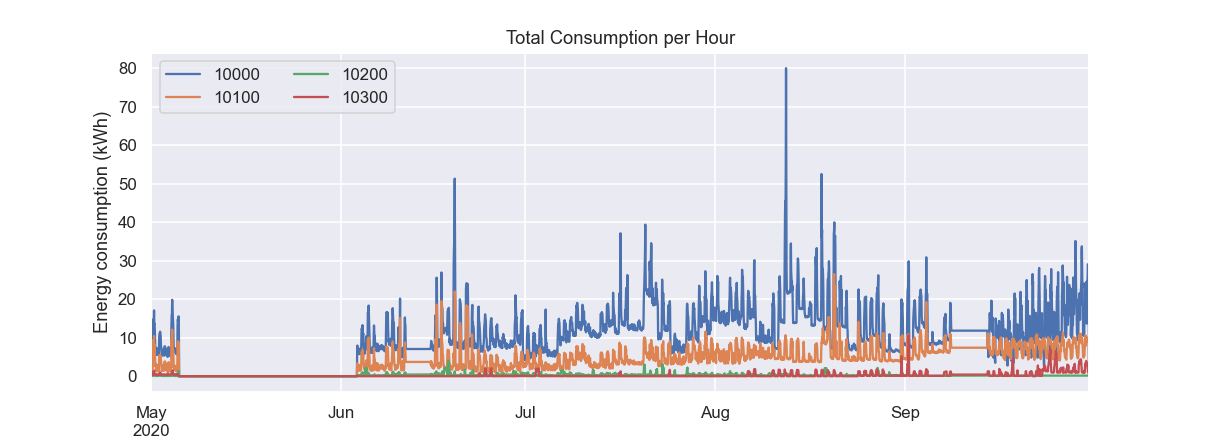

In [26]:
### Figure - Hourly Consumption 
sns.set(rc={'figure.figsize': (11, 4)})
sns.set(style='darkgrid')
hourly_consumption.loc[:,10000:10300].plot()
plt.ylabel("Energy consumption (kWh)")
plt.title("Total Consumption per Hour")
plt.legend(loc = "upper left",ncol=2)

<IPython.core.display.Javascript object>


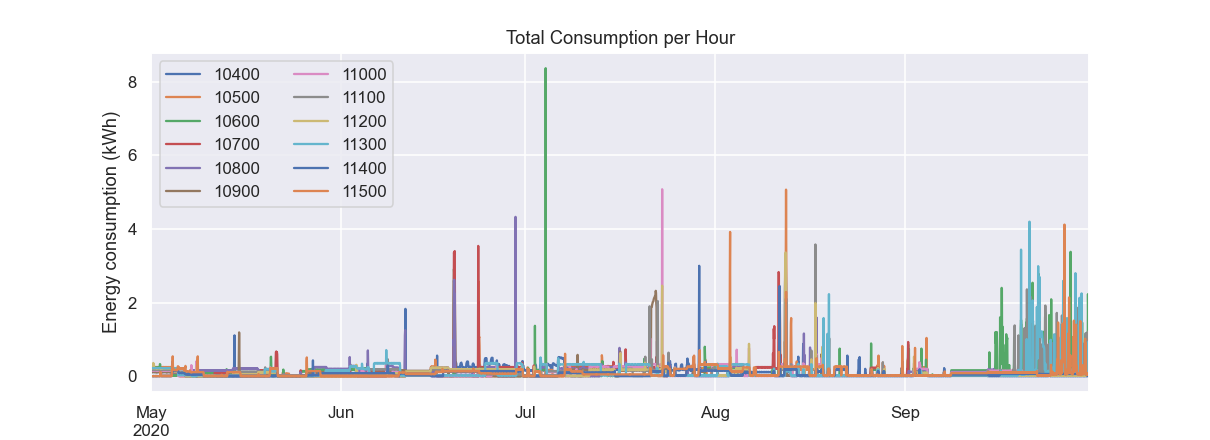

<IPython.core.display.Javascript object>


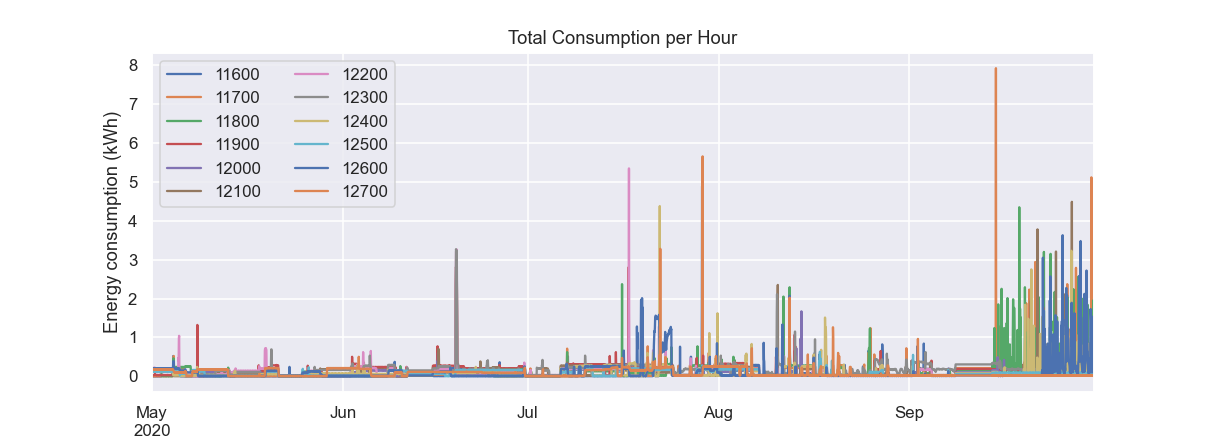

<IPython.core.display.Javascript object>


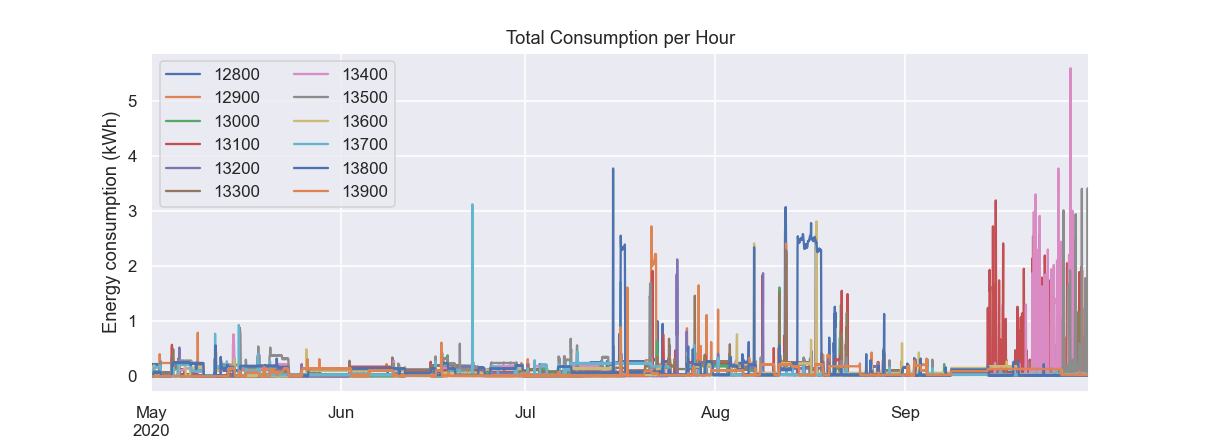

<IPython.core.display.Javascript object>


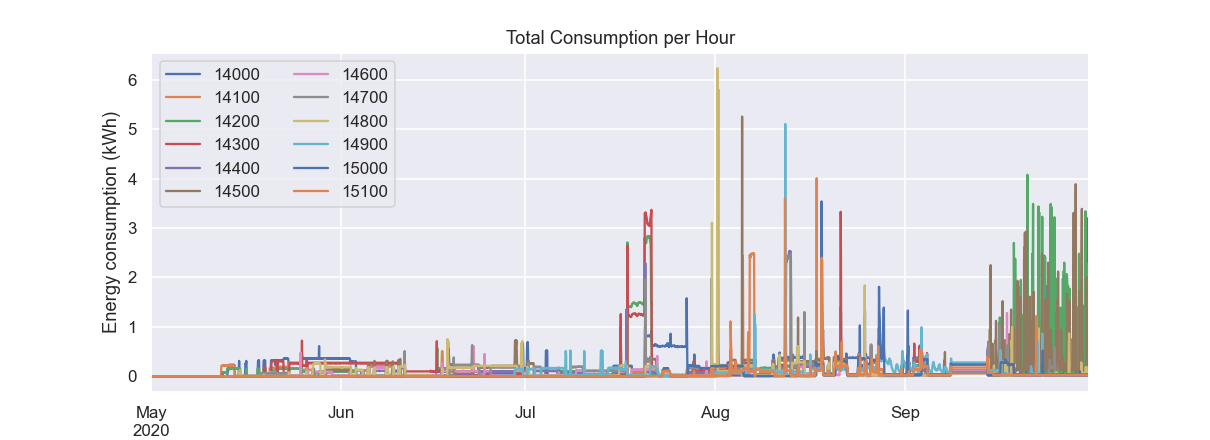

<IPython.core.display.Javascript object>


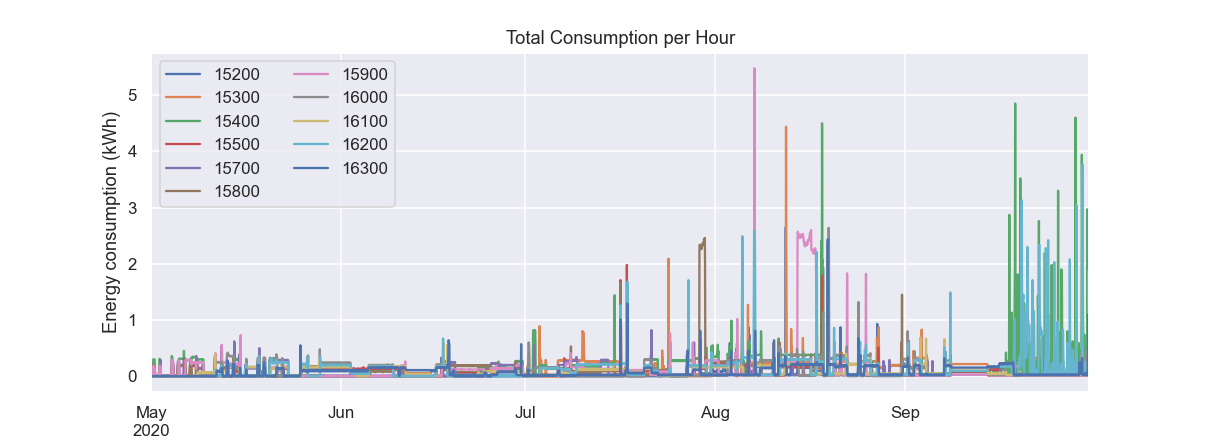

<IPython.core.display.Javascript object>


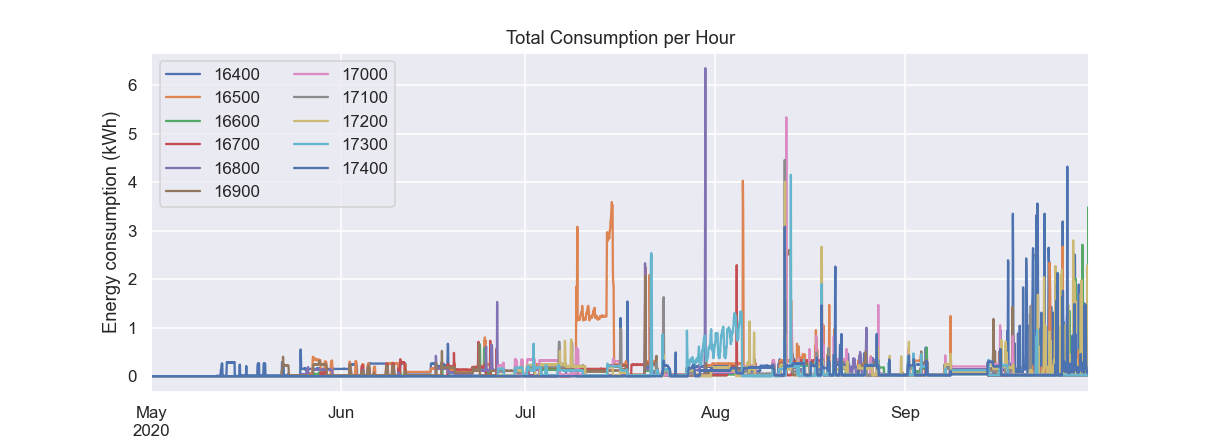

In [27]:
### Figure - Hourly Consumption 
for met in range(10400,17500,1200):
    sns.set(rc={'figure.figsize': (11, 4)})
    sns.set(style='darkgrid')
    hourly_consumption.loc[:,met:met+1100].plot()
    plt.ylabel("Energy consumption (kWh)")
    plt.title("Total Consumption per Hour")
    plt.legend(loc = "upper left",ncol=2)


<IPython.core.display.Javascript object>


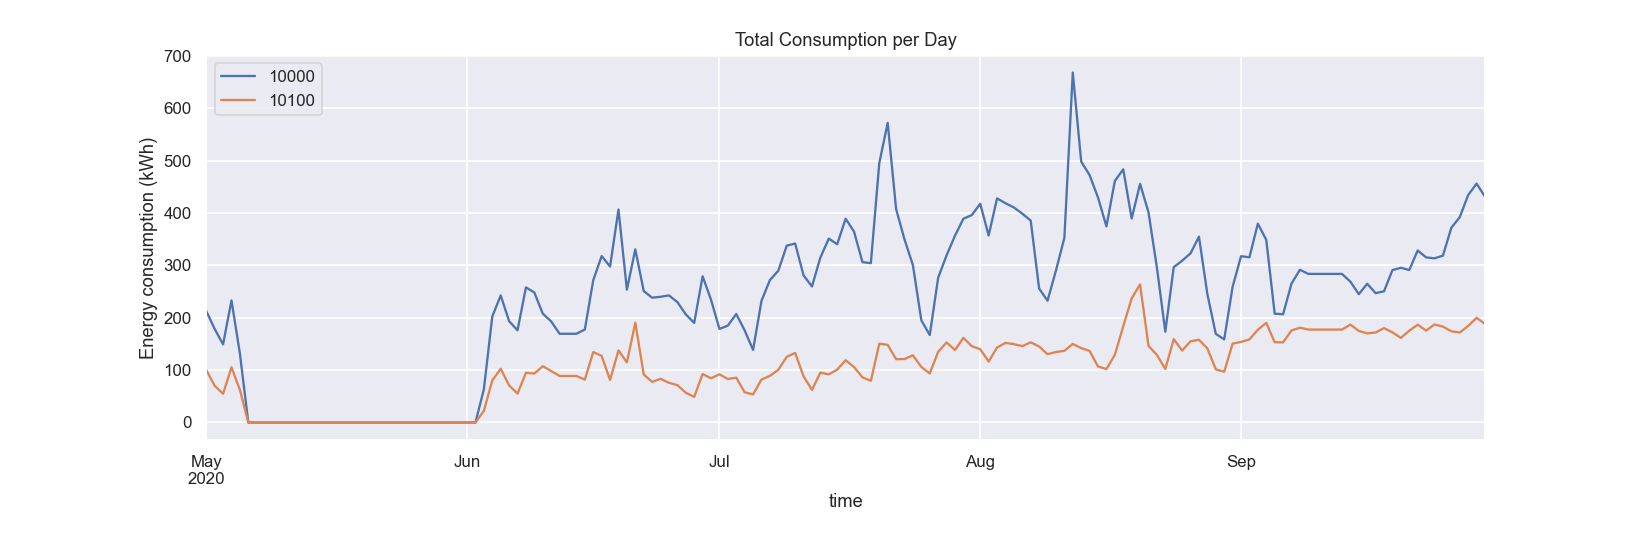

In [28]:
###  Figure 2 - Daily Consumption for Check Meter (10000) and House Meter (10100)
sns.set(rc={'figure.figsize': (15, 5)})
daily_total.loc[:,10000:10100].plot(kind ='line')
plt.ylabel("Energy consumption (kWh)")
plt.title("Total Consumption per Day")
plt.legend(loc = "upper left",ncol=1)
plt.subplots_adjust(bottom = 0.2, top = 0.9, wspace = 0.2, hspace= 0.4)

<IPython.core.display.Javascript object>


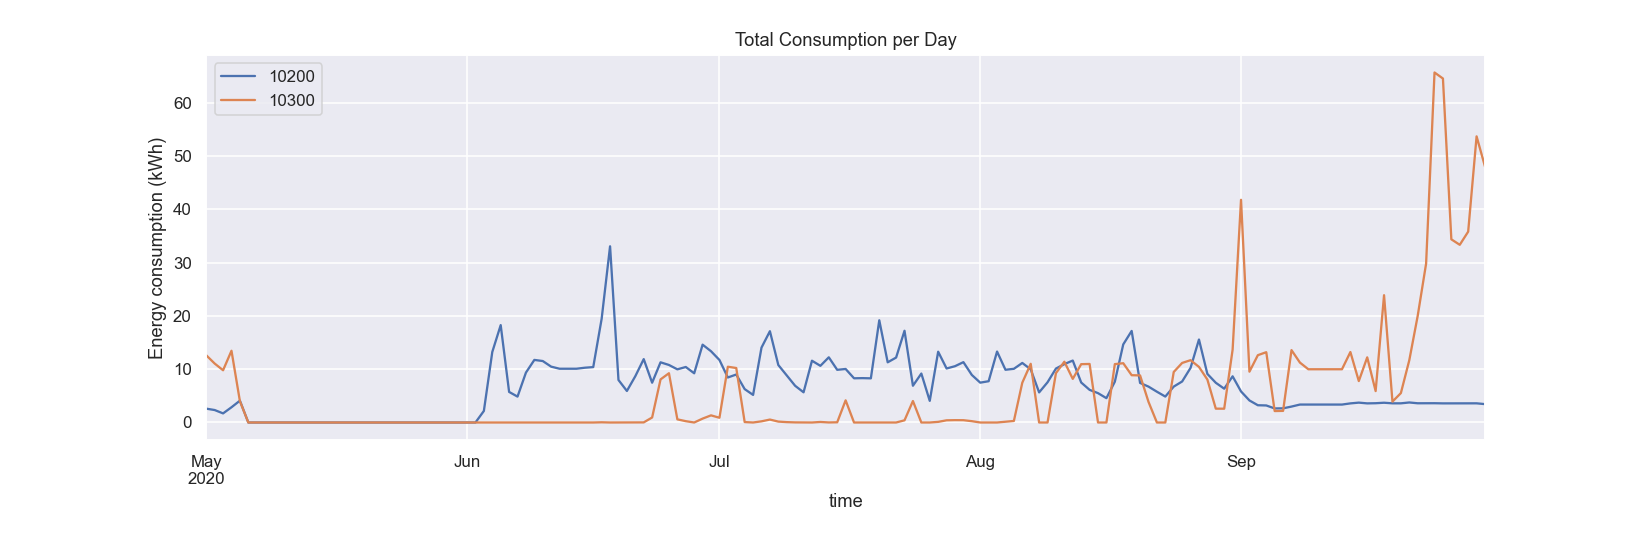

In [29]:
### Daily Consumption-  Commercial Tennants 1 and 2 (10200,10300)
sns.set(rc={'figure.figsize': (15, 5)})
daily_total.loc[:,10200:10300].plot()
plt.ylabel("Energy consumption (kWh)")
plt.title("Total Consumption per Day")
plt.legend(loc = "upper left",ncol=1)
plt.subplots_adjust(bottom = 0.2, top = 0.9, wspace = 0.2, hspace= 0.4)

<IPython.core.display.Javascript object>


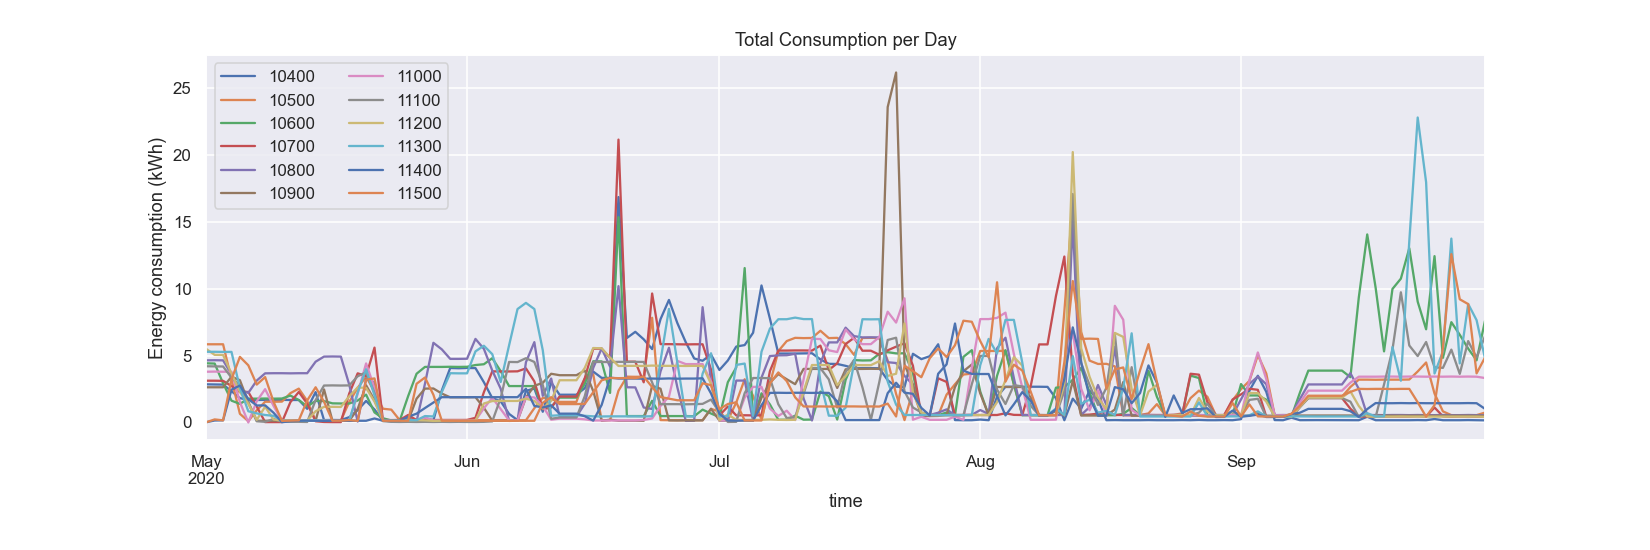

<IPython.core.display.Javascript object>


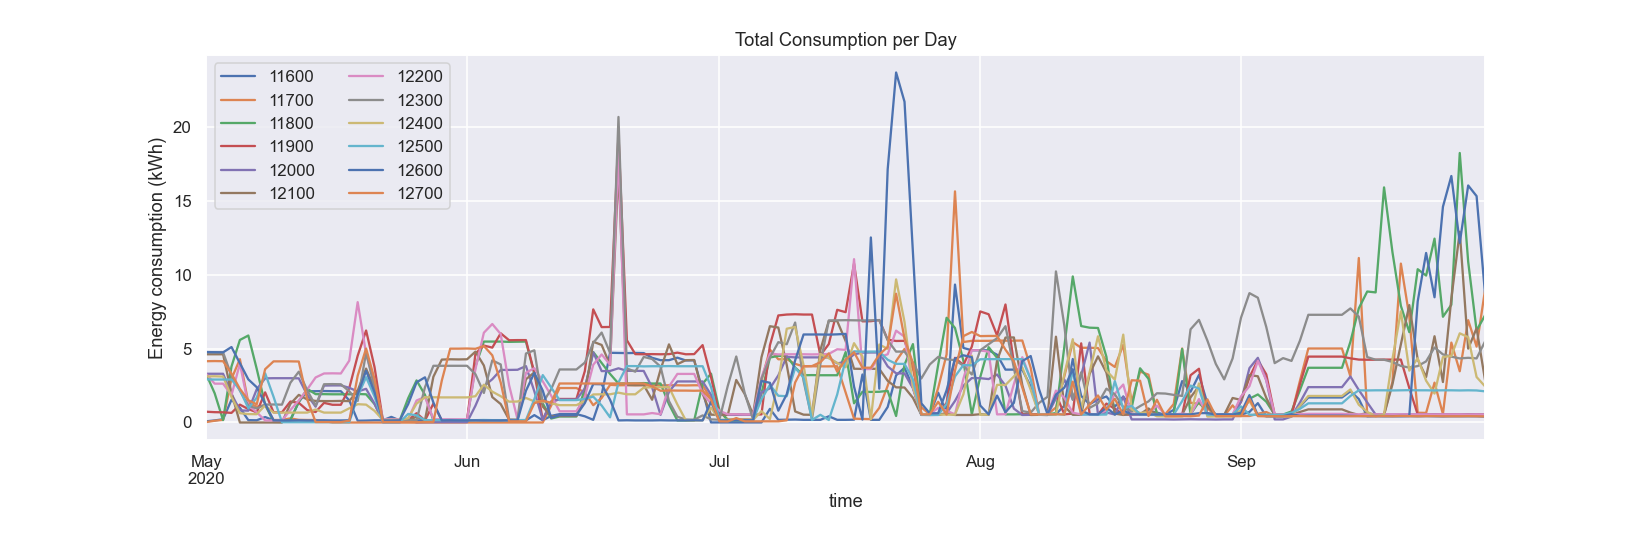

<IPython.core.display.Javascript object>


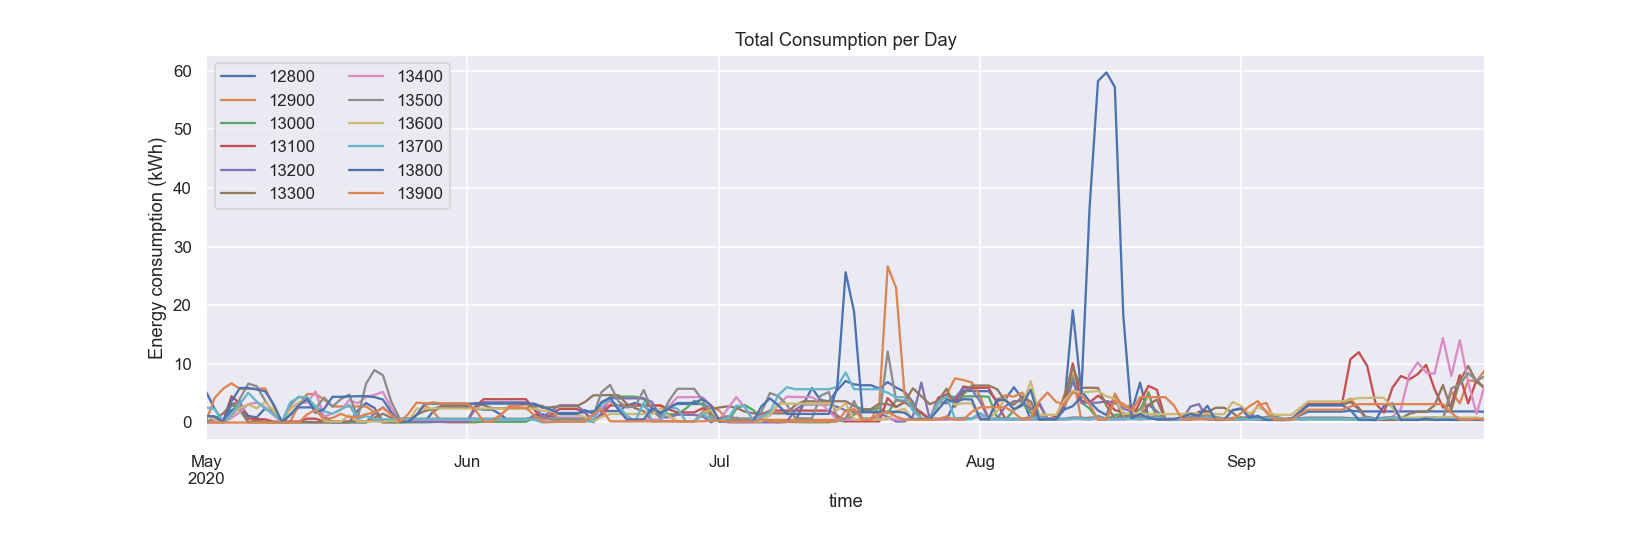

<IPython.core.display.Javascript object>


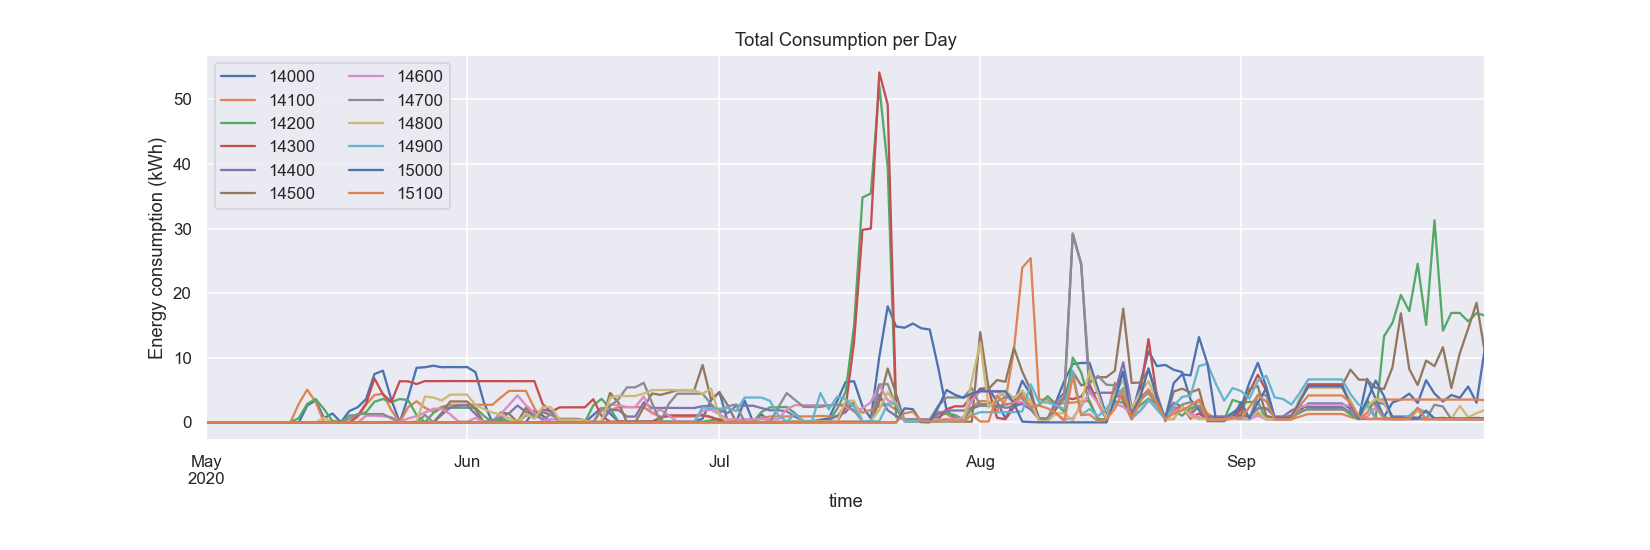

<IPython.core.display.Javascript object>


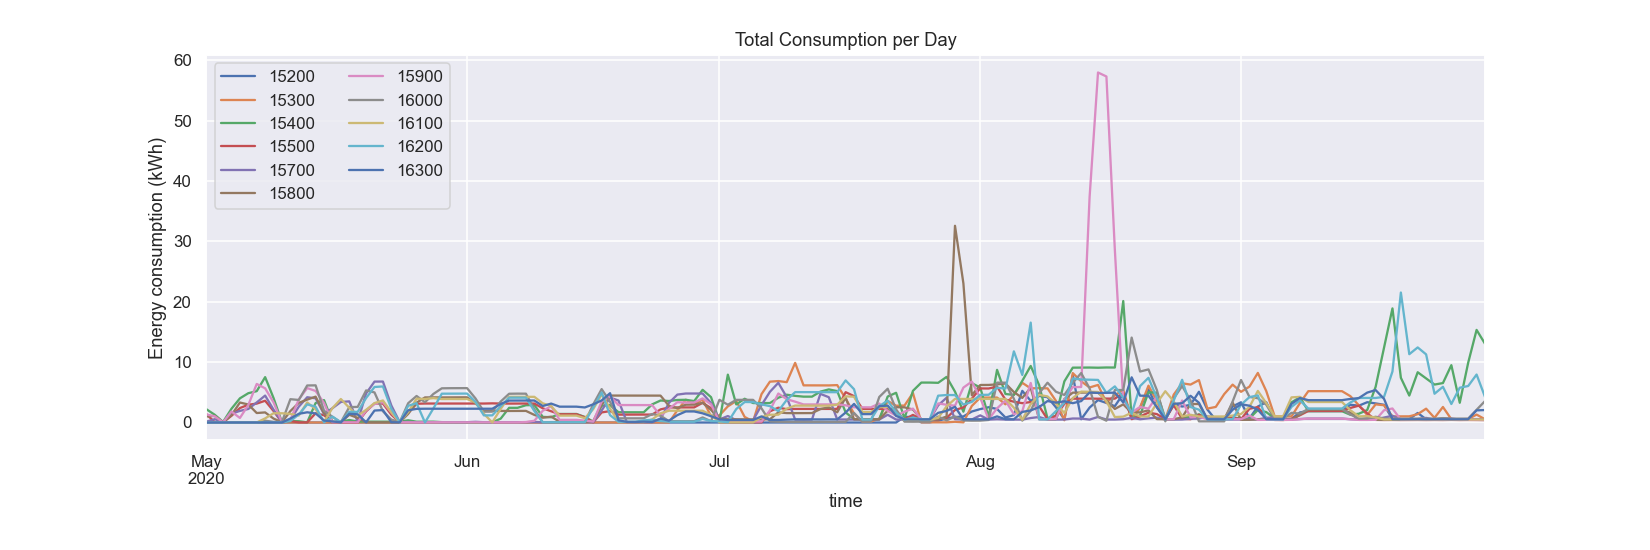

<IPython.core.display.Javascript object>


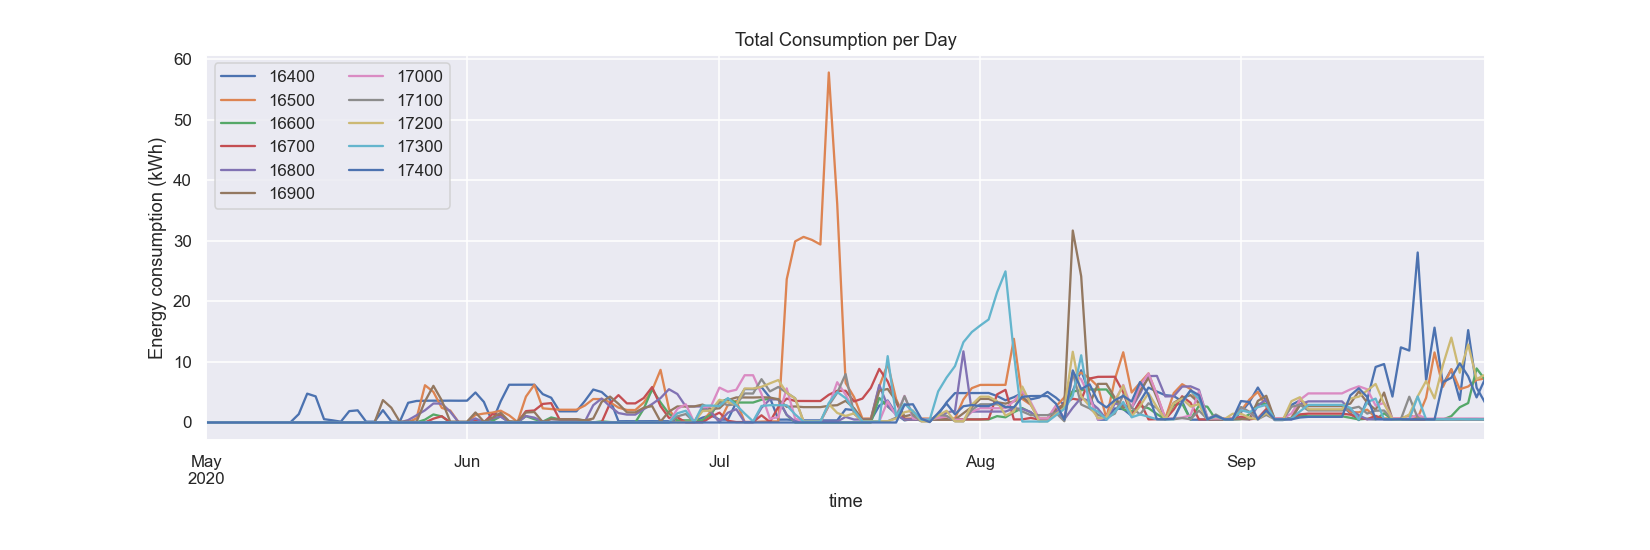

In [30]:
### Daily Consumption 
for met in range(10400,17500,1200):
    sns.set(rc={'figure.figsize': (15, 5)})
    daily_total.loc[:,met:met+1100].plot()
    plt.ylabel("Energy consumption (kWh)")
    plt.title("Total Consumption per Day")
    plt.legend(loc = "upper left",ncol=2)
    plt.subplots_adjust(bottom = 0.2, top = 0.9, wspace = 0.2, hspace= 0.4)

<IPython.core.display.Javascript object>


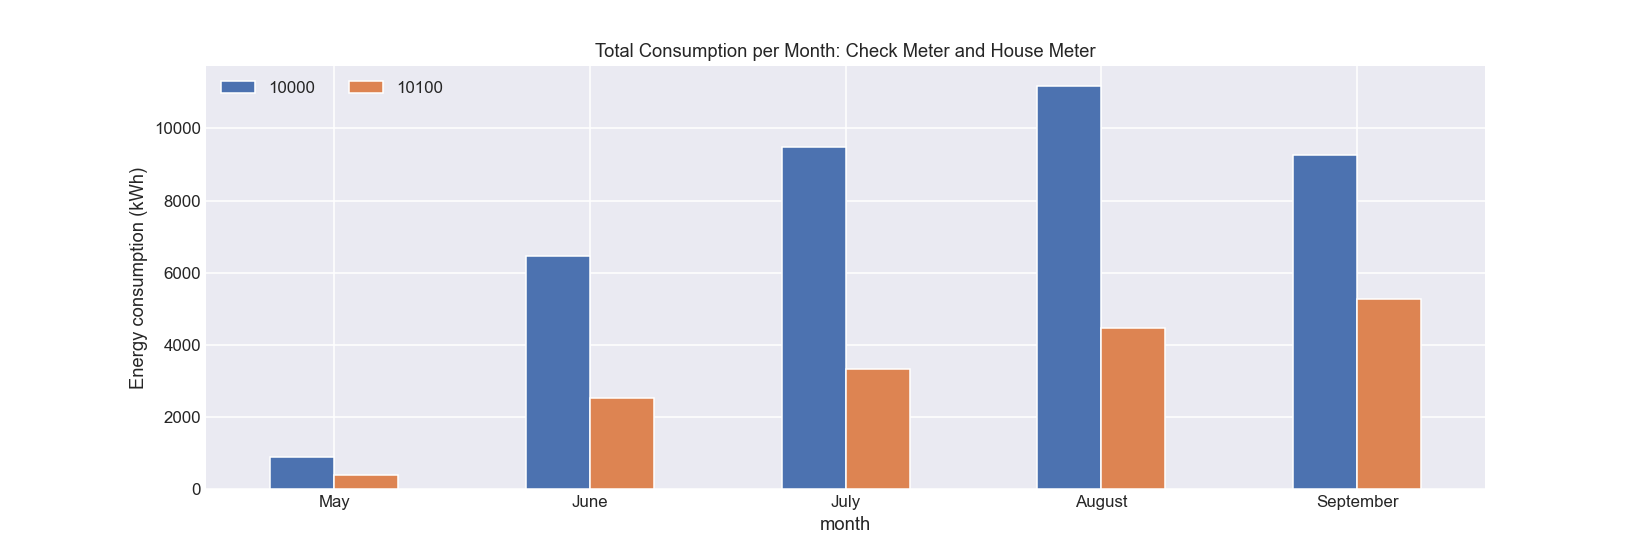

<IPython.core.display.Javascript object>


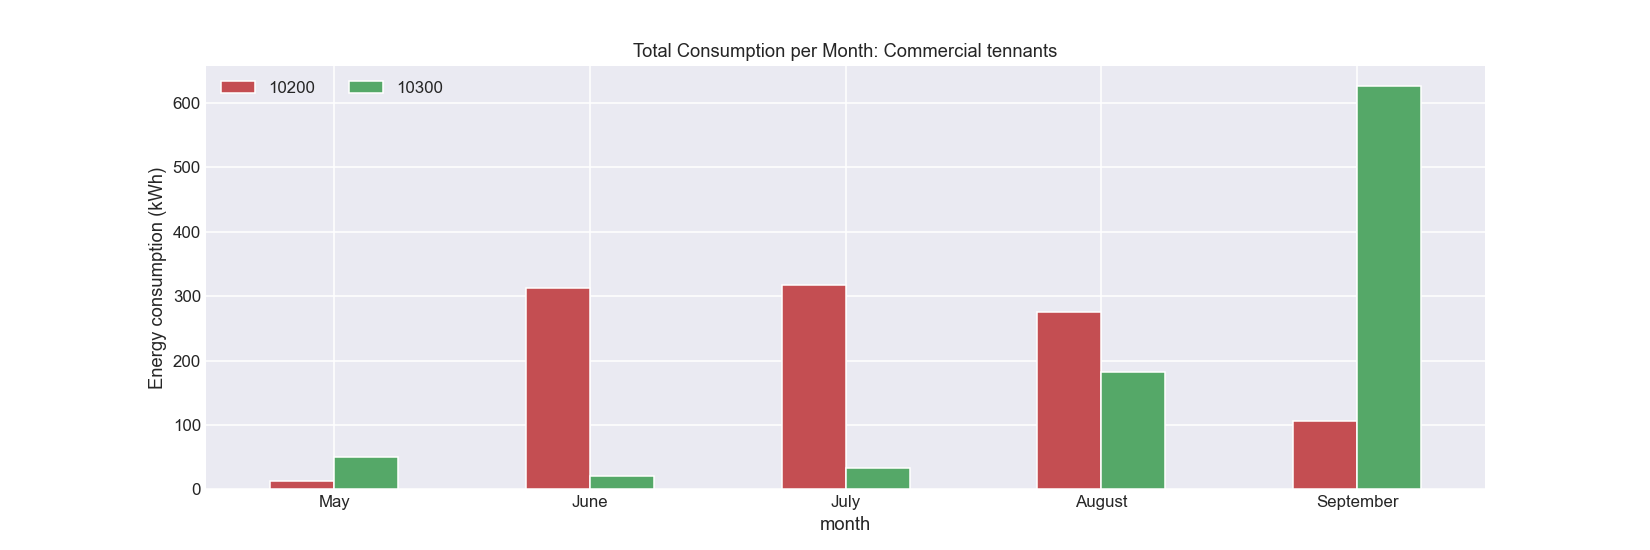

In [40]:
### Figure 3 - Monthly Consumption

E_monthly.pivot('month','meter','ActiveEnergy_consumption_kWh').loc[:,10000:10100].plot(kind='bar')
plt.title("Total Consumption per Month: Check Meter and House Meter")
plt.ylabel("Energy consumption (kWh)")
plt.xticks(rotation=0)
plt.legend(loc = 'upper left',ncol=2)

E_monthly.pivot('month','meter','ActiveEnergy_consumption_kWh').loc[:,10200:10300].plot(kind='bar', color='rgb')
plt.title("Total Consumption per Month: Commercial tennants")
plt.ylabel("Energy consumption (kWh)")
plt.xticks(rotation=0)
plt.legend(loc = 'upper left',ncol=2)

# monthly_total.plot(kind='line')



<IPython.core.display.Javascript object>


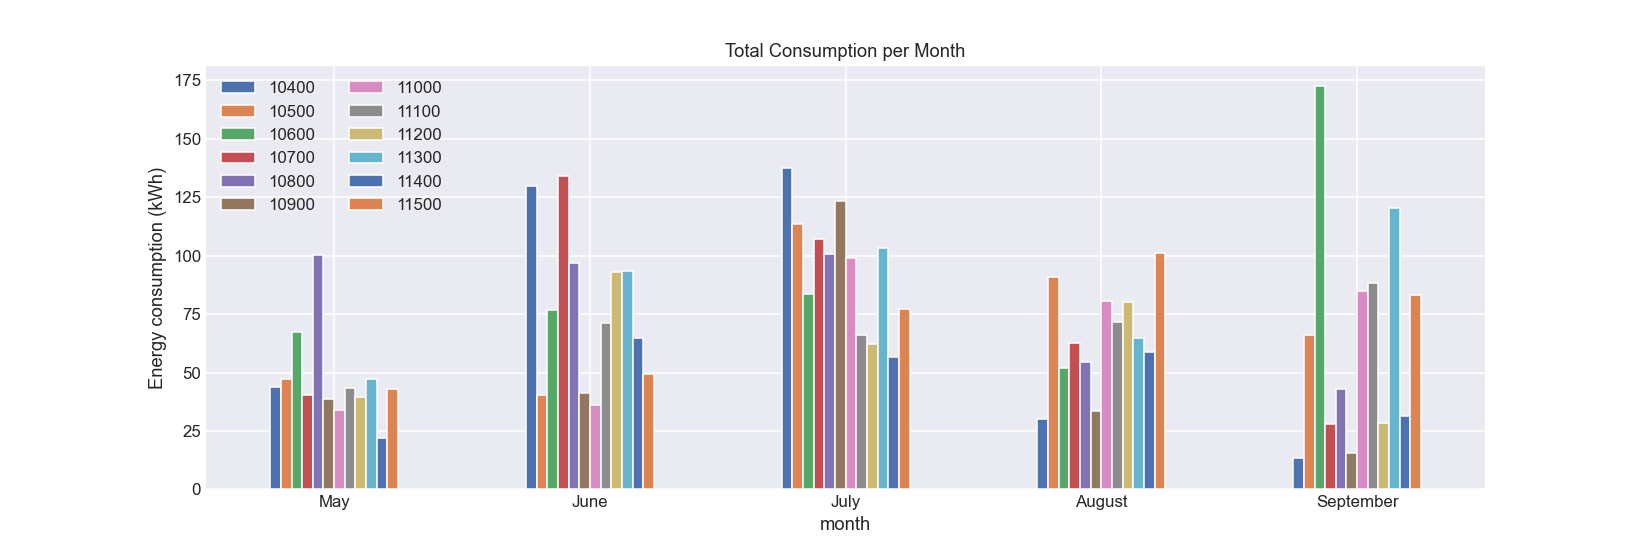

<IPython.core.display.Javascript object>


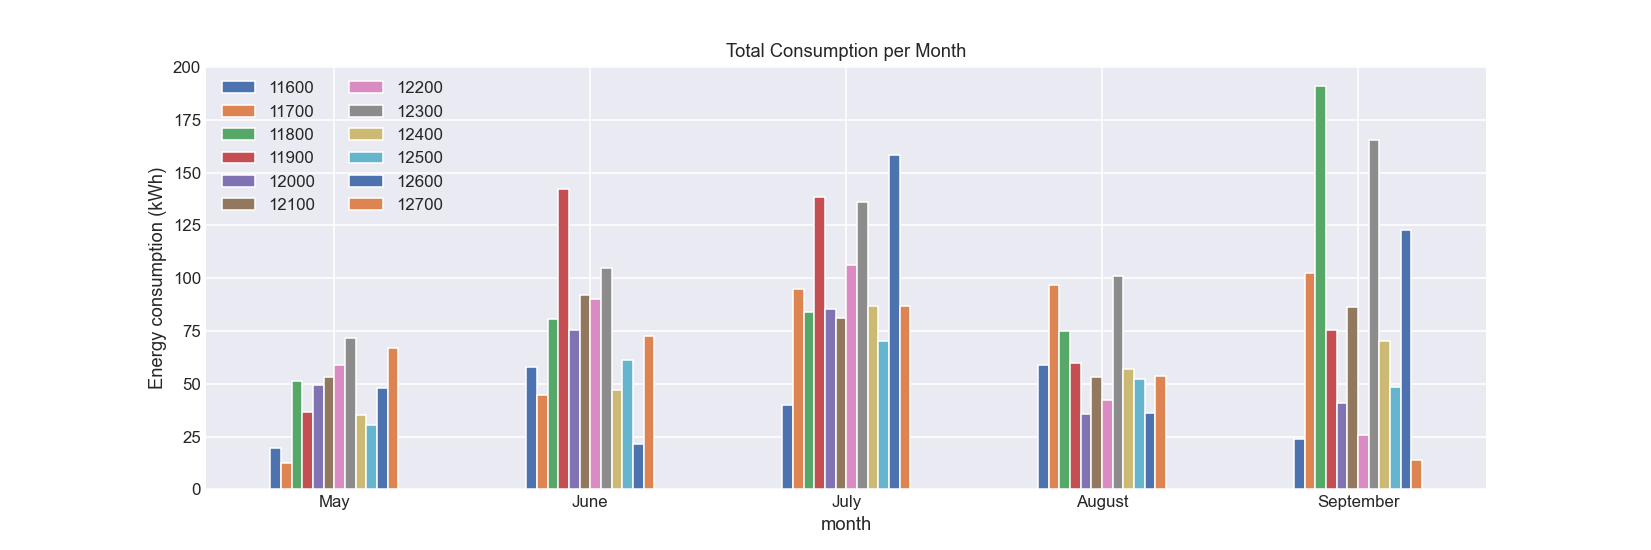

<IPython.core.display.Javascript object>


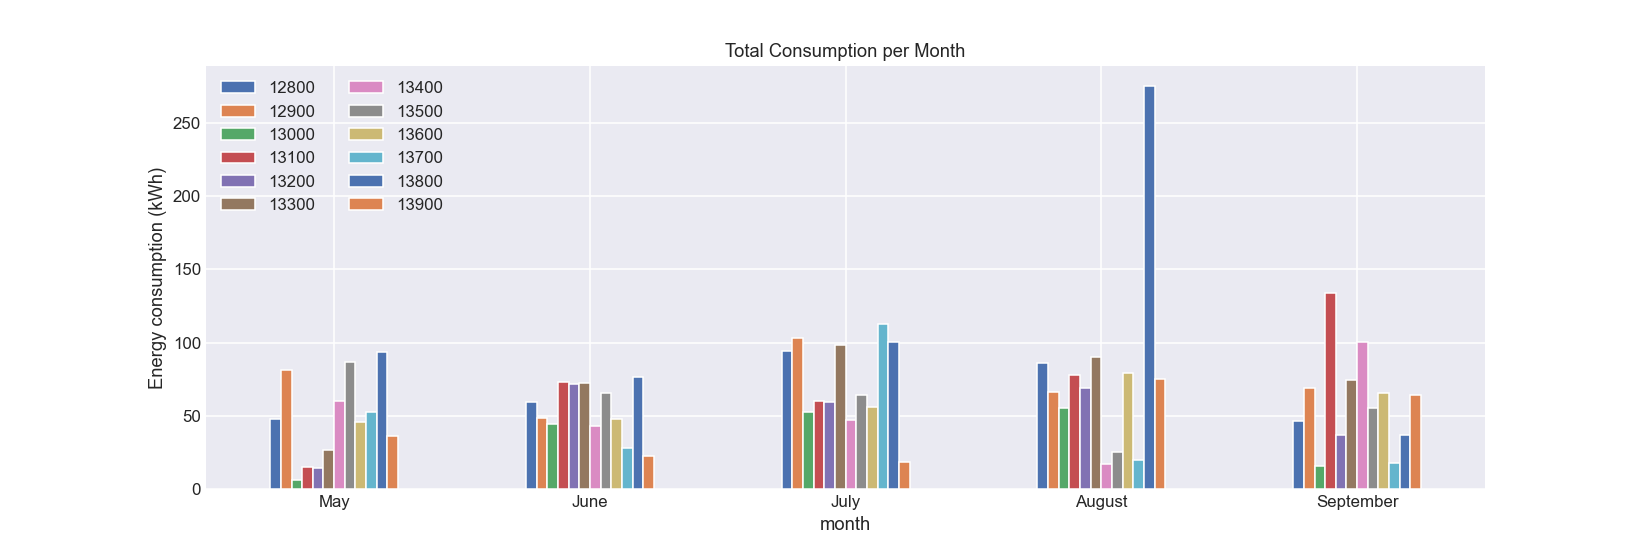

<IPython.core.display.Javascript object>


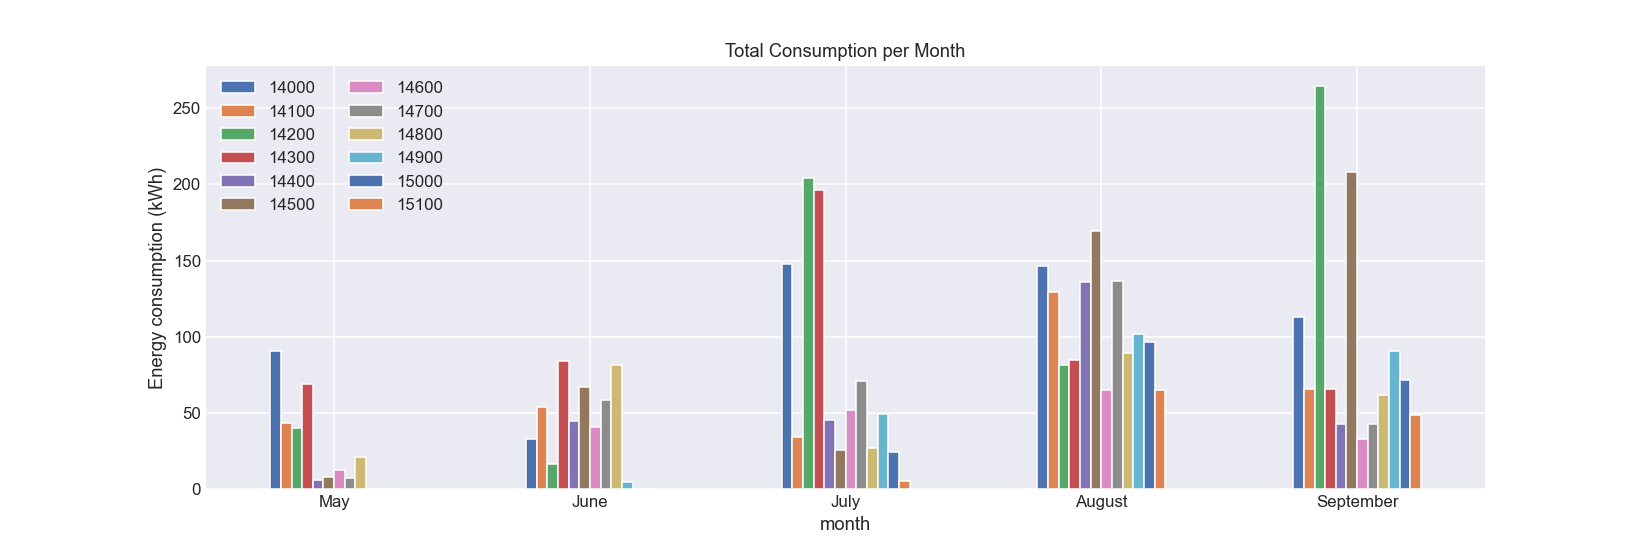

<IPython.core.display.Javascript object>


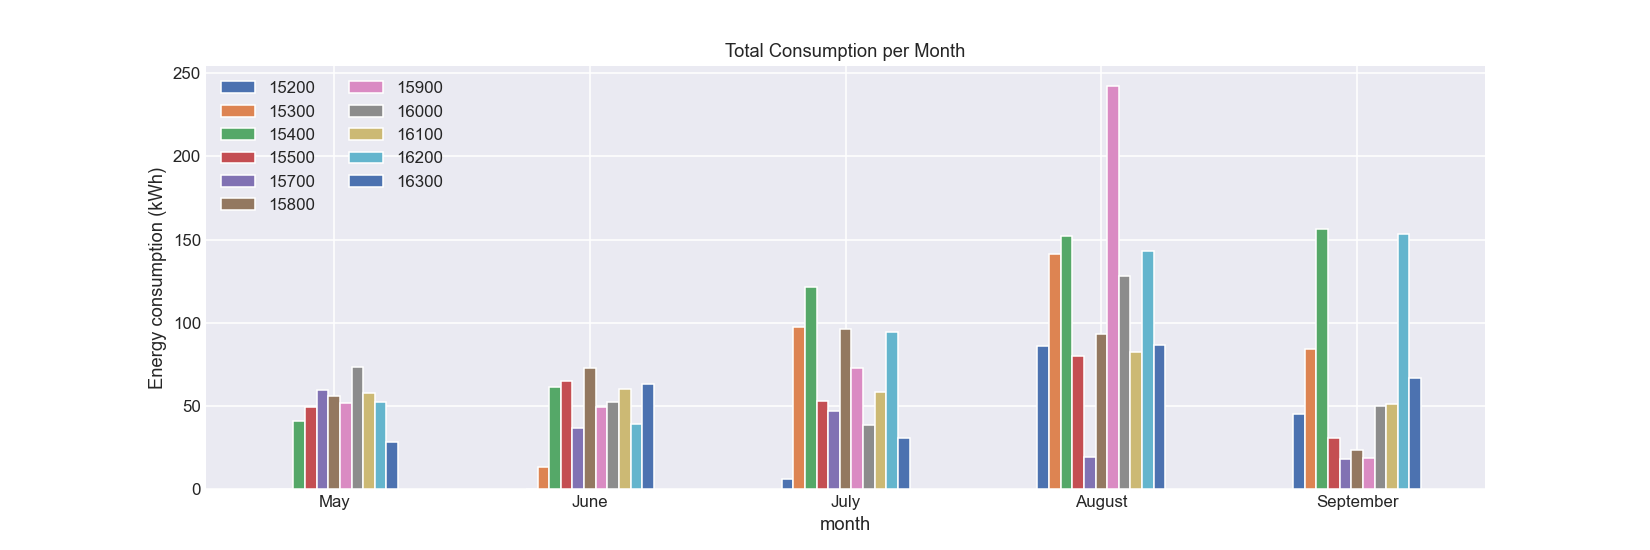

<IPython.core.display.Javascript object>


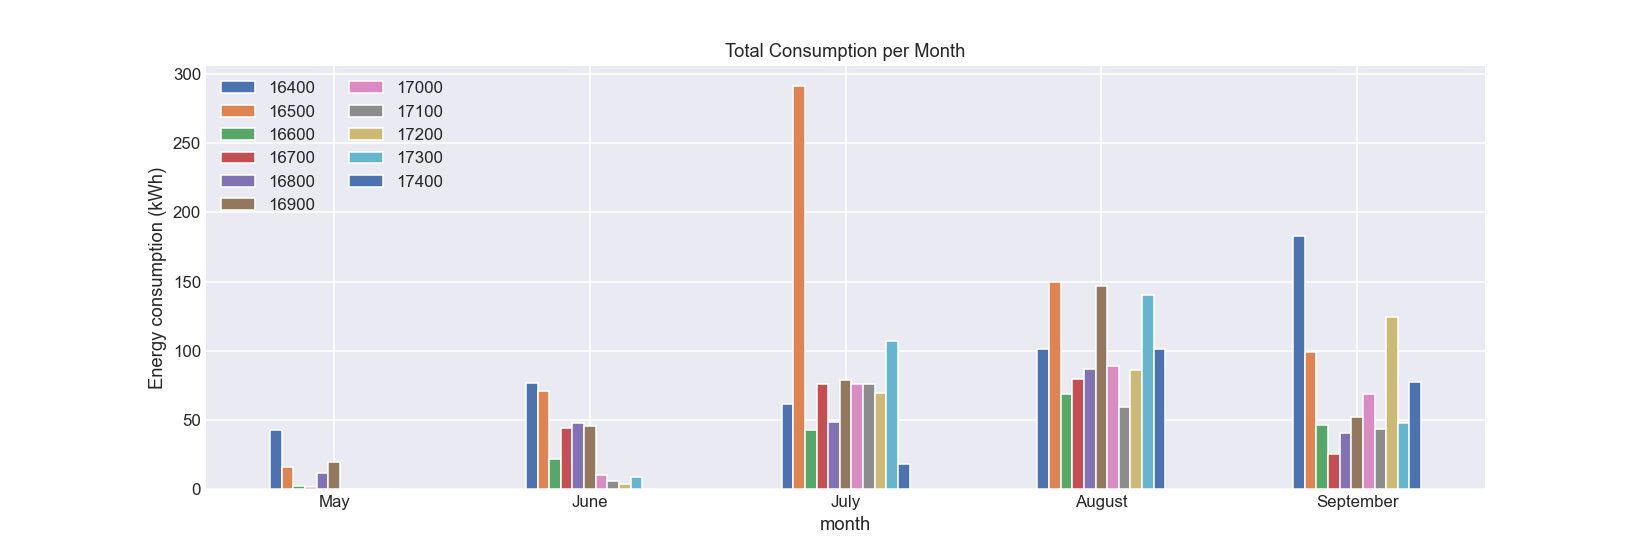

In [42]:
### Figure 3 - Monthly Consumption Meter 11200 to 12300 
for met in range(10400,17500,1200):
    E_monthly.pivot('month','meter','ActiveEnergy_consumption_kWh').loc[:,met:met+1100].plot(kind='bar')
    plt.title('Total Consumption per Month')
    plt.ylabel("Energy consumption (kWh)")
    plt.legend(loc = 'upper left',ncol=2)
    plt.xticks(rotation=0)

# monthly_total.plot(kind='line')

<IPython.core.display.Javascript object>


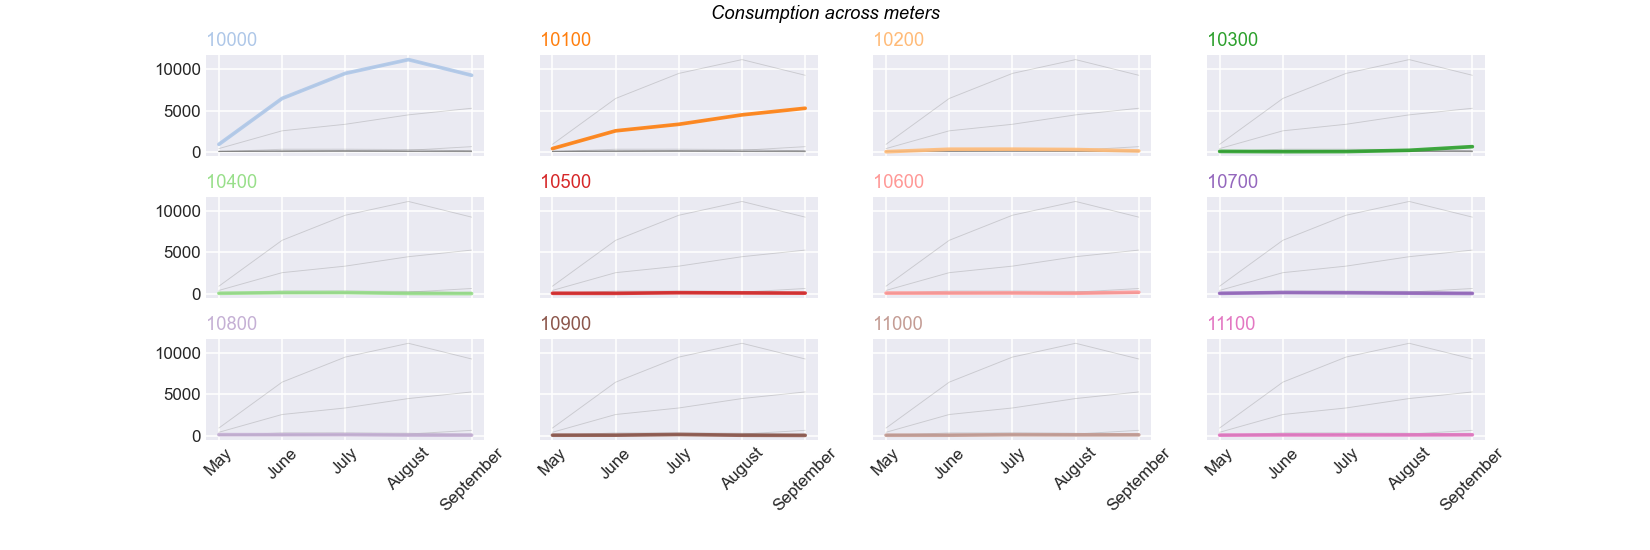

In [43]:
### Highlights individual meter consumption of Figure 2
# Number of Meters should be no more than 12, to be done in clusters 
#TODO: Create loop to display all plots 
monthly_total.iloc[:,:13]
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('tab20')
num = 0
for column in monthly_total.iloc[:,:13].drop('month',axis=1):
    num+=1
    plt.subplot(3,4,num)
    for v in monthly_total.iloc[:,:13].drop('month',axis =1):
        plt.plot(monthly_total.iloc[:,:13]['month'],monthly_total.iloc[:,:13][v],marker ='', color = 'grey', linewidth = 0.6, alpha=0.3)
    plt.plot(monthly_total.iloc[:,:13]['month'],monthly_total.iloc[:,:13][column], marker='', color=palette(num), linewidth=2.4, alpha=0.9, label=column)
    plt.xticks(rotation=45)
    if num in range(9):
        plt.tick_params(labelbottom= False)
    if num not in [1,5,9]:
        plt.tick_params(labelleft=False)
    plt.title(column, loc='left', fontsize=12, fontweight=0, color=palette(num))
plt.suptitle("Consumption across meters", fontsize=12,fontweight=0, color='black', style='italic', y=0.99)
plt.subplots_adjust(left = 0.125, right = 0.9, bottom = 0.2, top = 0.9, wspace = 0.2, hspace= 0.4)
plt.show()

<IPython.core.display.Javascript object>


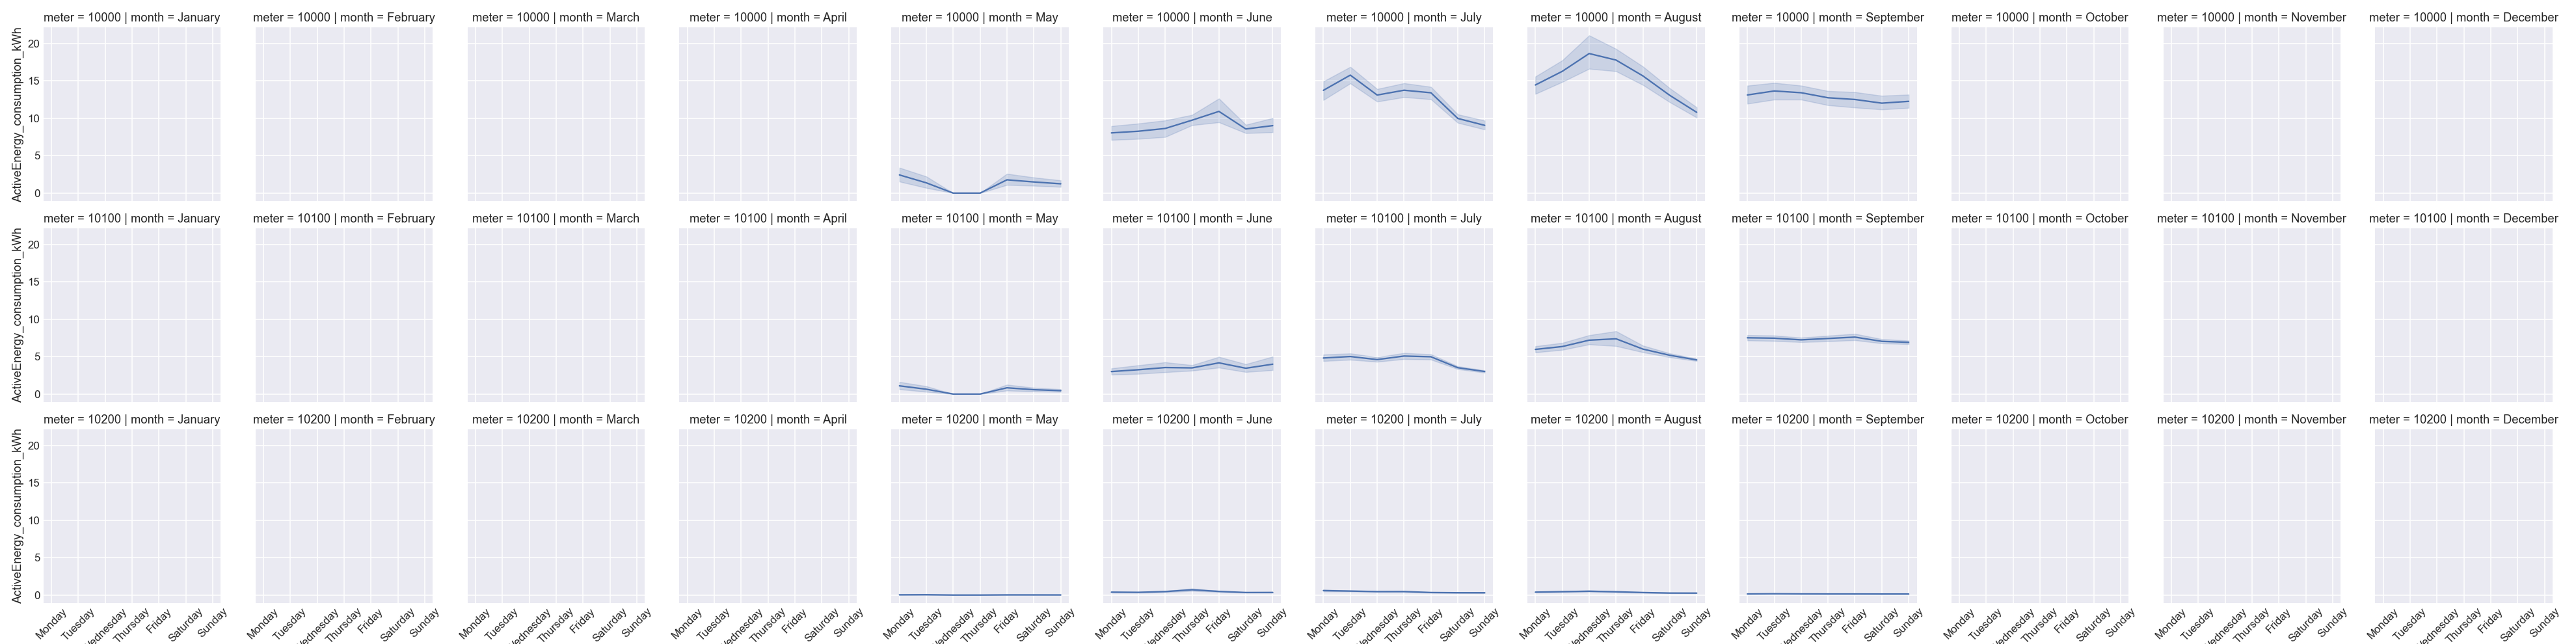

In [44]:
### To be done in clusters 
## lineplot aggregates repeated values and displays the mean with 95% CI
e  = sns.FacetGrid(EnergyConsumption_df.loc[EnergyConsumption_df['meter'].isin(range(10000,10300,100))], col = 'month',row = 'meter')
e.map(sns.lineplot,'day','ActiveEnergy_consumption_kWh')
e.set_xticklabels(rotation=45)

<IPython.core.display.Javascript object>


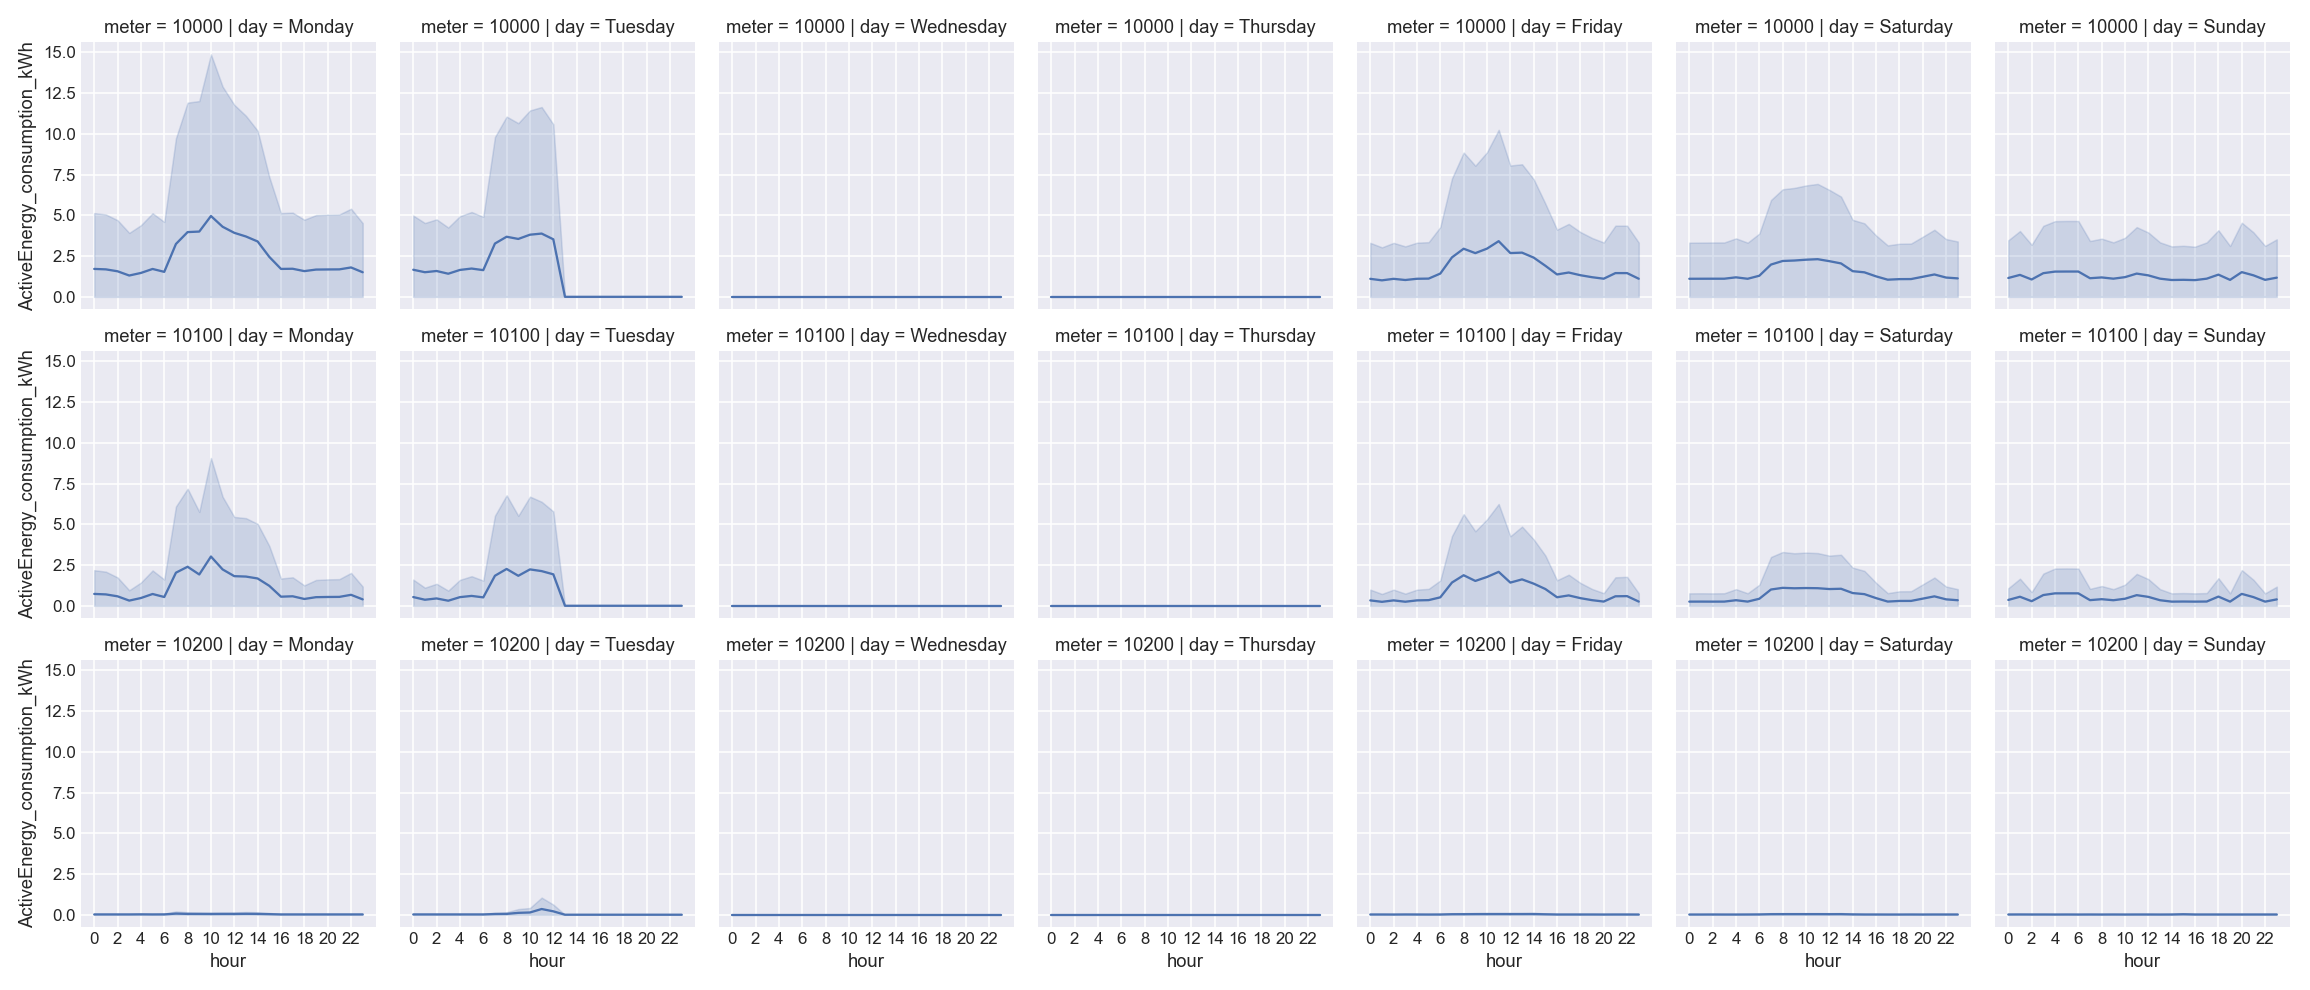

In [45]:
### To be done in clusters 
###  Select which month to analyse (i.e. August)
M = EnergyConsumption_df.loc[EnergyConsumption_df['meter'].isin(range(10000,10300,100))].groupby(['month']).get_group('May')
Mo = sns.FacetGrid(M,col='day', row = 'meter')
Mo.map(sns.lineplot,'hour','ActiveEnergy_consumption_kWh')
Mo.set(xticks=range(0,24,2))

<IPython.core.display.Javascript object>


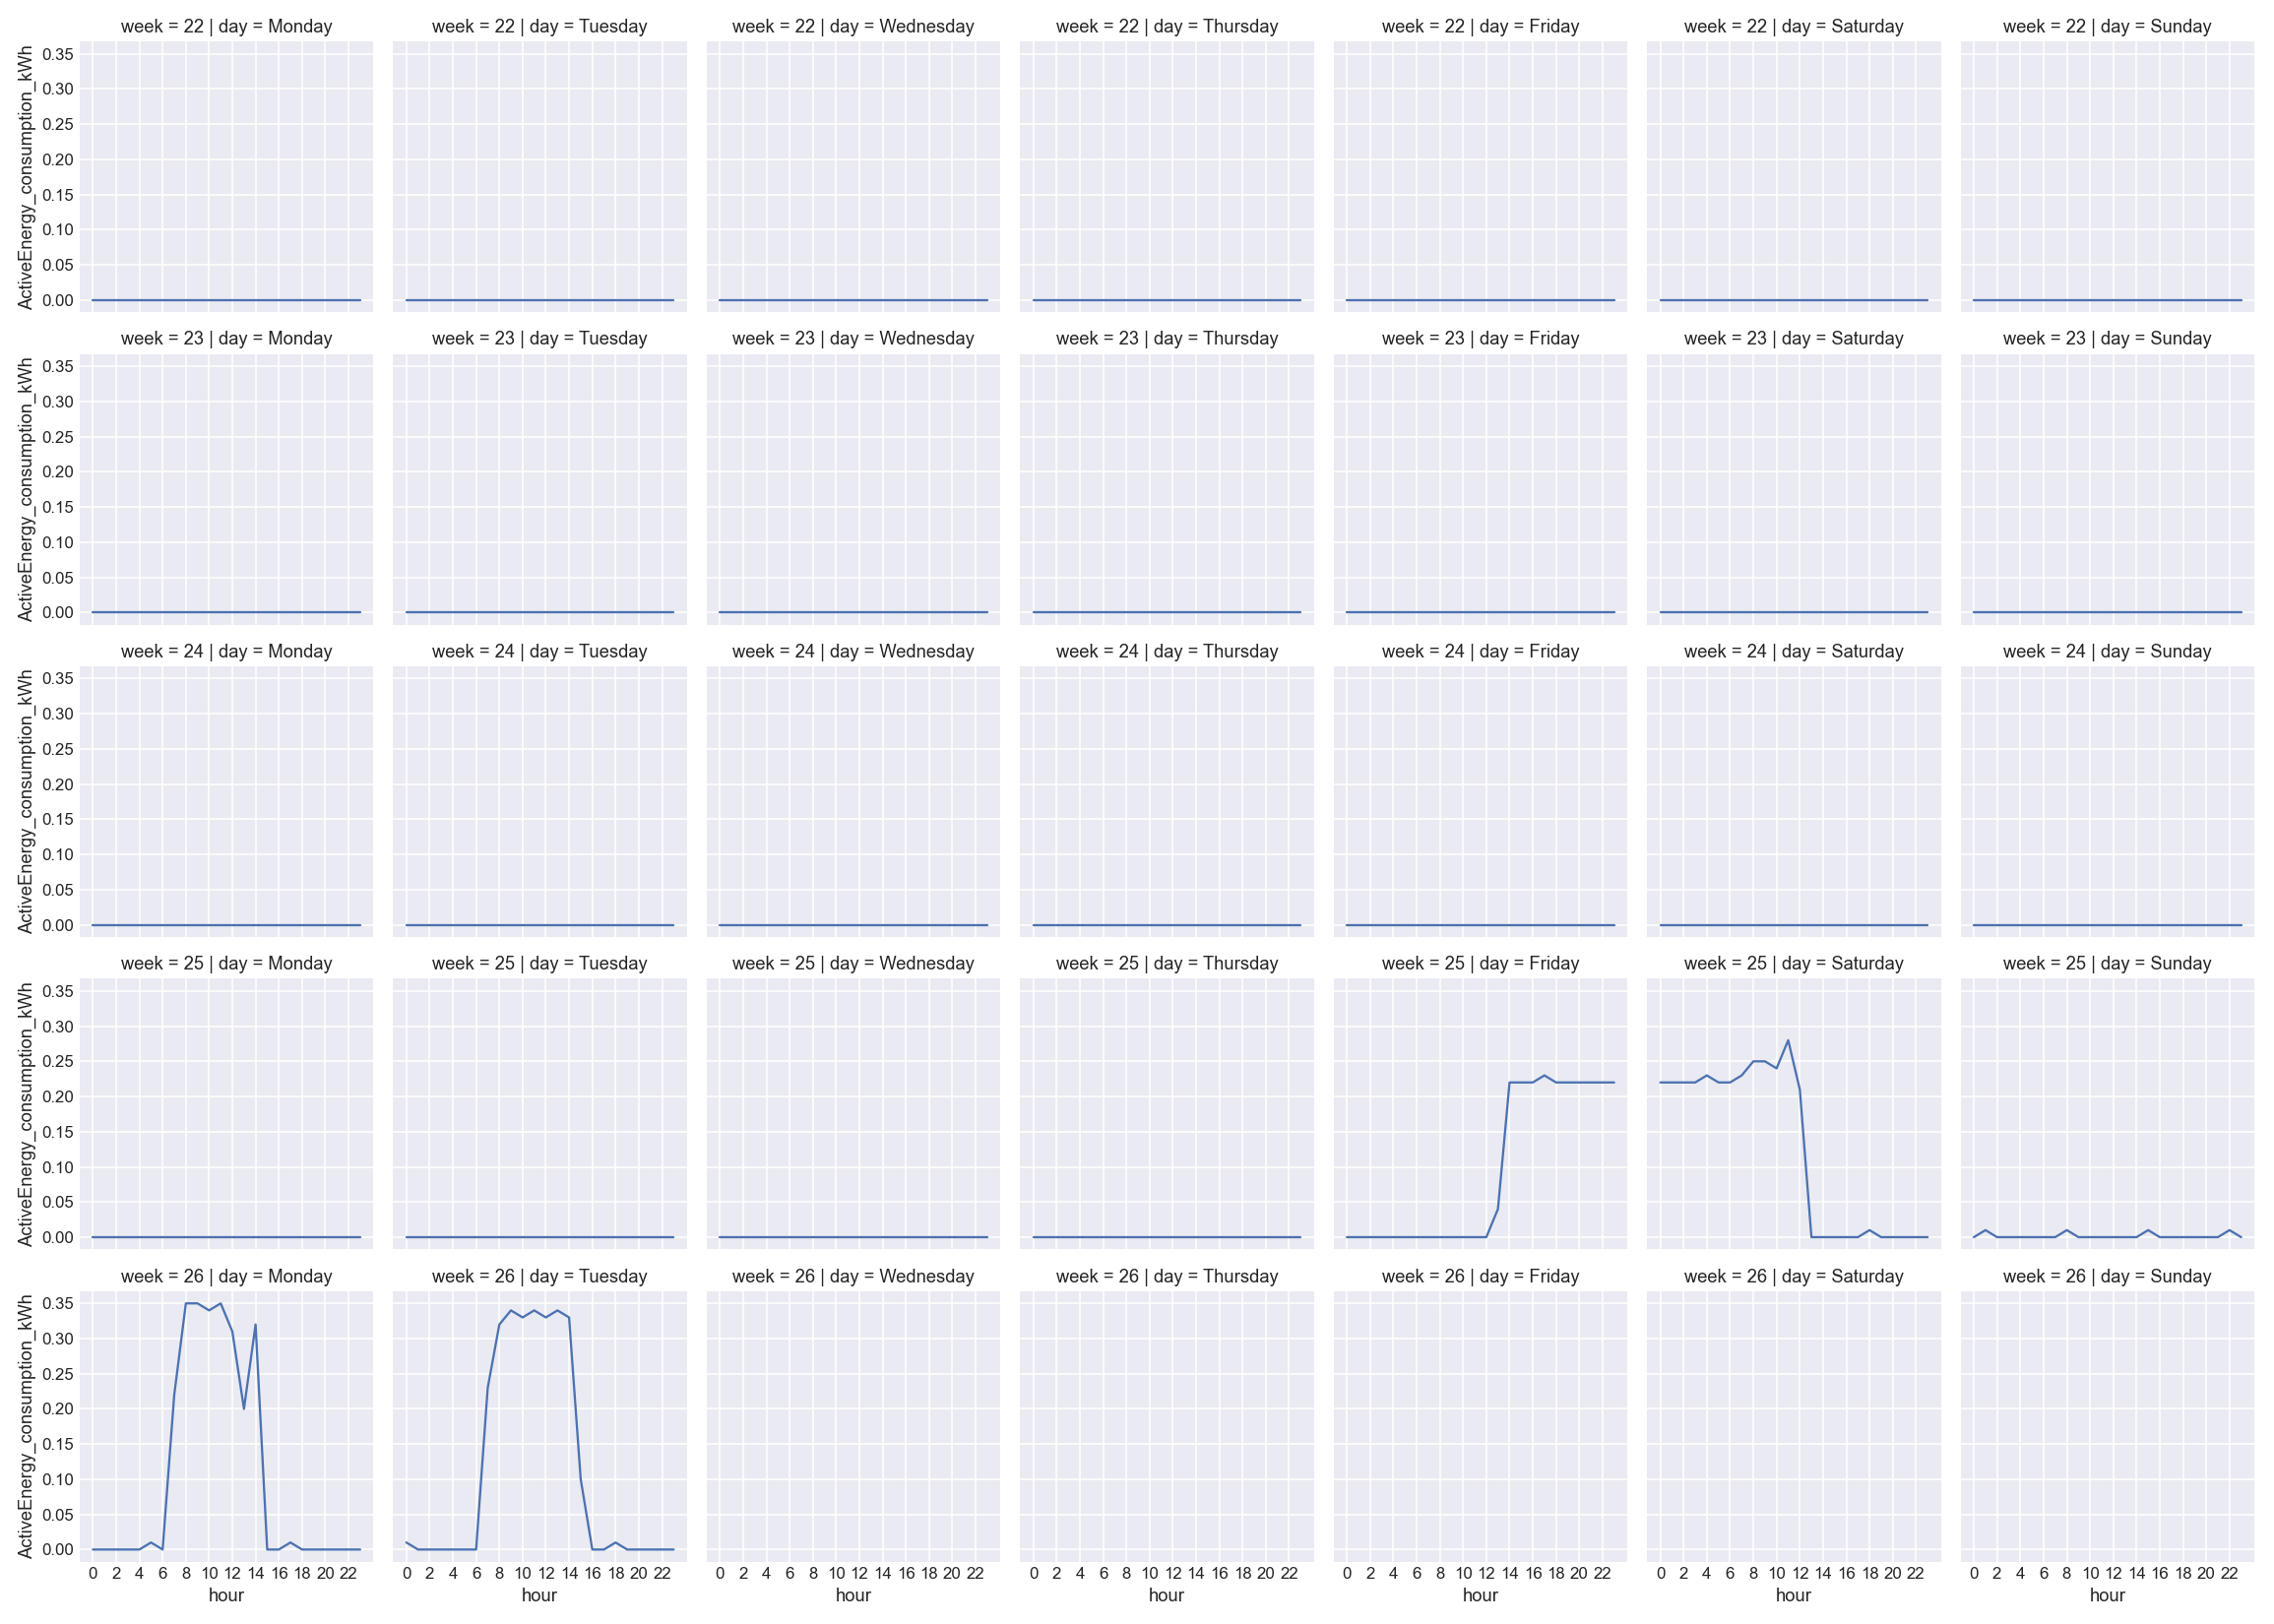

Wall time: 3.82 s


In [46]:
%%time 
### Matches with Optergy graphs
###  Select which month and meter to analyse (i.e. August)
me = EnergyConsumption_df.groupby(['month','meter']).get_group(("June",17000))
metr = sns.FacetGrid(me,col='day', row = 'week')
metr.map(sns.lineplot,'hour','ActiveEnergy_consumption_kWh')
# metr.map(sns.barplot,'hour','ActiveEnergy_consumption_kWh')
metr.set(xticks=range(0,24,2))

<IPython.core.display.Javascript object>


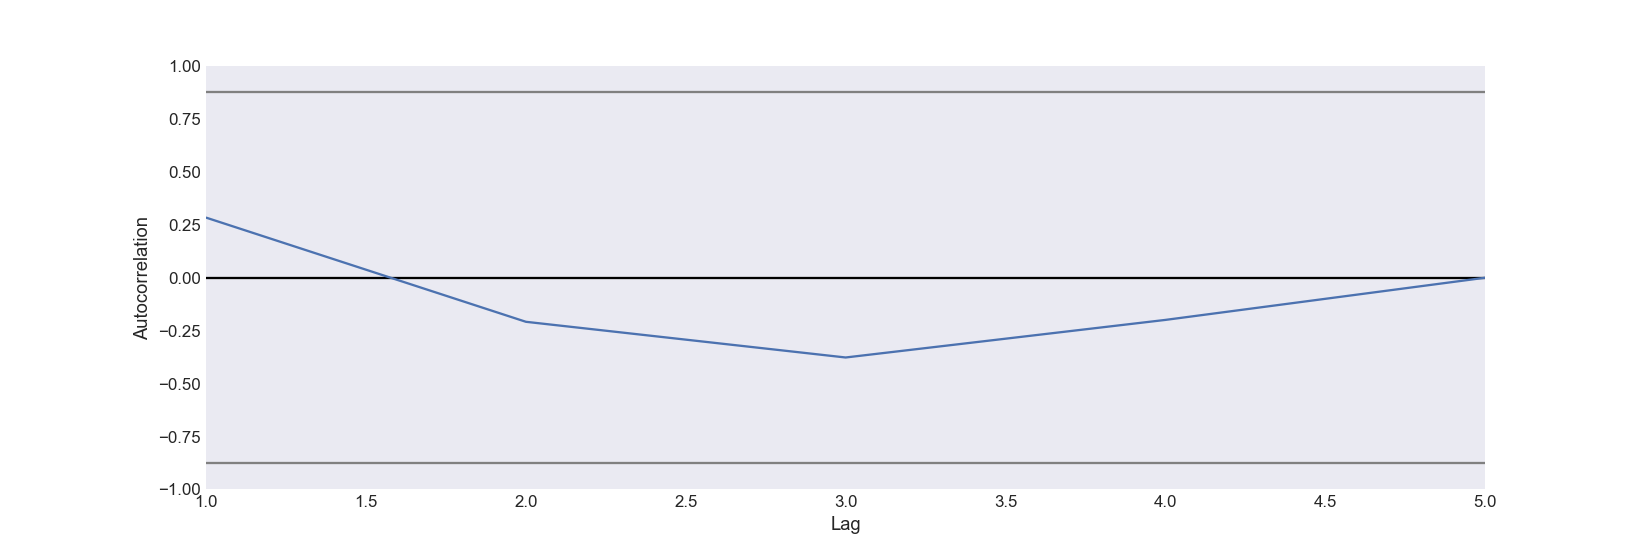

In [47]:
### Autocorrelation plot, select individual meter to analyse 
df_m1 = df[df["meter"] == 10000]
df_m1 = df_m1.set_index('time')
pd.plotting.autocorrelation_plot(df_m1["ActiveEnergy_consumption_kWh"].resample("1m").median())